# Monut

In [ ]:
#mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# New Preprocessing ( pivoted glucose col's )

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from datetime import timedelta

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/MINI01/processed-diabetes-data/combined_data.csv')

In [ ]:
data.head()

,Code,Value,patient_id,datetime
0,58,100,1,1991-04-21 09:09:00
1,33,9,1,1991-04-21 09:09:00
2,34,13,1,1991-04-21 09:09:00
3,62,119,1,1991-04-21 17:08:00
4,33,7,1,1991-04-21 17:08:00


In [ ]:
print(data.head())
print(data.info())
print(data['Code'].value_counts())  # Check distribution of codes

   Code Value  patient_id             datetime
0    58   100           1  1991-04-21 09:09:00
1    33     9           1  1991-04-21 09:09:00
2    34    13           1  1991-04-21 09:09:00
3    62   119           1  1991-04-21 17:08:00
4    33     7           1  1991-04-21 17:08:00
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29285 entries, 0 to 29284
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Code        29285 non-null  int64 
 1   Value       29252 non-null  object
 2   patient_id  29285 non-null  int64 
 3   datetime    29285 non-null  object
dtypes: int64(2), object(2)
memory usage: 915.3+ KB
None
Code
33    9480
34    3828
58    3516
62    3158
60    2770
48    1883
35    1053
57     990
64     904
65     331
67     326
63     219
66     154
70     139
56     119
71      98
72      94
69      68
61      66
68      34
0       33
59      20
4        1
36       1
Name: count, dtype: int64


In [ ]:
# Step 1: Data Cleaning
data['Value'] = pd.to_numeric(data['Value'], errors='coerce')
data['Value'] = data['Value'].fillna(0)
data['datetime'] = pd.to_datetime(data['datetime'])

#baba 63 ookate add cheyali

# Step 2: Preprocess the Data
glucose_codes = [48, 57, 58, 59, 60, 61, 62, 64]
long_acting_codes = [34, 35]

pivoted_data = data.pivot_table(index=['patient_id', 'datetime'],
                                columns='Code',
                                values='Value',
                                aggfunc='first').reset_index()

In [ ]:
pivoted_data = pivoted_data.fillna(0)
pivoted_data['Glucose'] = pivoted_data[glucose_codes].max(axis=1)
pivoted_data['Insulin_LongActing'] = pivoted_data[long_acting_codes].max(axis=1)
pivoted_data['Insulin_Regular'] = pivoted_data.get(33, 0)
pivoted_data['Hypoglycemia'] = pivoted_data.get(65, 0).apply(lambda x: 1 if x > 0 else 0)

In [ ]:
# Cap high glucose values
glucose_upper_limit = 300
outliers = pivoted_data[pivoted_data['Glucose'] > glucose_upper_limit]
if not outliers.empty:
    print("Glucose values above 300 mg/dL (capped at 300):")
    print(outliers[['patient_id', 'datetime', 'Glucose']])
pivoted_data['Glucose'] = pivoted_data['Glucose'].clip(upper=glucose_upper_limit)

pivoted_data = pivoted_data.drop(columns=[col for col in pivoted_data.columns if isinstance(col, (int, float))])
pivoted_data['datetime'] = pd.to_datetime(pivoted_data['datetime'])
pivoted_data = pivoted_data.sort_values(['patient_id', 'datetime'])

pivoted_data['Hour'] = pivoted_data['datetime'].dt.hour
pivoted_data['Minute'] = pivoted_data['datetime'].dt.minute
pivoted_data['Glucose'] = pivoted_data.groupby('patient_id')['Glucose'].transform(lambda x: x.replace(0, np.nan).ffill())
pivoted_data['Glucose'] = pivoted_data['Glucose'].fillna(0)

Glucose values above 300 mg/dL (capped at 300):
Code   patient_id            datetime  Glucose
11              1 1991-04-24 22:09:00    340.0
42              1 1991-05-03 07:48:00    305.0
72              1 1991-05-10 17:30:00    343.0
125             1 1991-05-26 09:17:00    312.0
146             1 1991-06-01 09:20:00    313.0
...           ...                 ...      ...
18298          70 1989-04-28 18:00:00    389.0
18306          70 1989-05-01 08:00:00    349.0
18307          70 1989-05-01 18:00:00    400.0
18309          70 1989-05-02 18:00:00    302.0
18319          70 1989-05-06 18:00:00    378.0

[775 rows x 3 columns]


In [ ]:
# Keep a copy of the datetime for plotting later
pivoted_data_with_time = pivoted_data.copy()

# Save the modified data to a CSV file
output_path = '/content/drive/MyDrive/MINI01/processed-diabetes-data/modified_data.csv'
pivoted_data_with_time.to_csv(output_path, index=False)
print(f"Modified data saved to {output_path}")

Modified data saved to /content/drive/MyDrive/MINI01/processed-diabetes-data/modified_data.csv


In [ ]:
# Keep a copy of the datetime for plotting later
pivoted_data_with_time = pivoted_data.copy()
pivoted_data = pivoted_data.drop(columns=['datetime'])

# Step 3: Prepare Sequences and Track Patient IDs
features = ['Hour', 'Minute', 'Glucose', 'Insulin_LongActing', 'Hypoglycemia']
target = 'Insulin_Regular'
window_size = 7

In [ ]:
X, y, patient_ids, timestamps = [], [], [], []
for patient in pivoted_data['patient_id'].unique():
    patient_data = pivoted_data[pivoted_data['patient_id'] == patient].copy()
    patient_data_with_time = pivoted_data_with_time[pivoted_data_with_time['patient_id'] == patient].copy()

    if len(patient_data) < window_size + 1:
        continue

    for i in range(len(patient_data) - window_size):
        X.append(patient_data[features].iloc[i:i+window_size].values)
        y.append(patient_data[target].iloc[i+window_size])
        patient_ids.append(patient)
        timestamps.append(patient_data_with_time['datetime'].iloc[i+window_size])

In [ ]:
X = np.array(X)
y = np.array(y)
patient_ids = np.array(patient_ids)
timestamps = np.array(timestamps)

In [ ]:
# Normalize features
X_reshaped = X.reshape(-1, len(features))
scaler_features = StandardScaler()
X_normalized = scaler_features.fit_transform(X_reshaped)
X_normalized = X_normalized.reshape(X.shape)

# Scale the target (Insulin_Regular)
scaler_target = StandardScaler()
y = scaler_target.fit_transform(y.reshape(-1, 1)).flatten()

# Step 4: Split Data
X_temp, X_test, y_temp, y_test, patient_ids_temp, patient_ids_test, timestamps_temp, timestamps_test = train_test_split(
    X_normalized, y, patient_ids, timestamps, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val, patient_ids_train, patient_ids_val, timestamps_train, timestamps_val = train_test_split(
    X_temp, y_temp, patient_ids_temp, timestamps_temp, test_size=0.2, random_state=42)

# model01: LSTM-Transformer ( 0.53 )

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, MultiHeadAttention, Dense, Dropout, LayerNormalization, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
import pandas as pd
import os

In [ ]:
# Define input shape (assuming window_size and features are defined earlier in your code)
input_layer = Input(shape=(window_size, len(features)))

# Stacked LSTM Layers for better temporal feature extraction
lstm_output_1 = LSTM(256, return_sequences=True, kernel_regularizer=l2(0.005), return_state=False)(input_layer)
lstm_output_1 = LayerNormalization()(lstm_output_1)
lstm_output_1 = Dropout(0.2)(lstm_output_1)  # Reduced dropout to retain more information

lstm_output_2 = LSTM(128, return_sequences=True, kernel_regularizer=l2(0.005))(lstm_output_1)
lstm_output_2 = LayerNormalization()(lstm_output_2)
lstm_output_2 = Dropout(0.2)(lstm_output_2)

# Transformer Encoder with more heads for better attention
attention_output = MultiHeadAttention(num_heads=8, key_dim=128)(lstm_output_2, lstm_output_2)
attention_output = Dropout(0.2)(attention_output)
attention_output = LayerNormalization()(attention_output)

# Add a second Transformer layer for deeper feature extraction
attention_output_2 = MultiHeadAttention(num_heads=8, key_dim=128)(attention_output, attention_output)
attention_output_2 = Dropout(0.2)(attention_output_2)
attention_output_2 = LayerNormalization()(attention_output_2)

# Fully Connected Layers with more capacity
dense_output = Dense(128, activation='relu', kernel_regularizer=l2(0.005))(attention_output_2[:, -1, :])
dense_output = BatchNormalization()(dense_output)
dense_output = Dropout(0.2)(dense_output)

dense_output_2 = Dense(64, activation='relu', kernel_regularizer=l2(0.005))(dense_output)
dense_output_2 = BatchNormalization()(dense_output_2)
dense_output_2 = Dropout(0.2)(dense_output_2)

# Output Layer
output_layer = Dense(1)(dense_output_2)

In [ ]:
# Compile Model
lstm_transformer_model = Model(inputs=input_layer, outputs=output_layer)
lstm_transformer_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Lower learning rate
                               loss='mse',
                               metrics=['mae'])

# Model Summary
lstm_transformer_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 7, 5)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 7, 256)         │        268,288 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 7, 256)         │            512 │ lstm[0][0]             │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 7, 256)         │              0 │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 7, 128)         │        197,120 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 7, 128)         │            256 │ lstm_1[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 7, 128)         │              0 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 7, 128)         │        527,488 │ dropout_1[0][0],       │
│ (MultiHeadAttention)      │                        │                │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 7, 128)         │              0 │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 7, 128)         │            256 │ dropout_3[0][0]        │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 7, 128)         │        527,488 │ layer_normalization_2… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 7, 128)         │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_3     │ (None, 7, 128)         │            256 │ dropout_5[0][0]        │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 128)            │              0 │ layer_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │         16,512 │ get_item[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 128)            │            512 │ dense[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 1,547,265 (5.90 MB)

 Trainable params: 1,546,881 (5.90 MB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
# Training with Early Stopping and Learning Rate Reduction
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

history = lstm_transformer_model.fit(
    X_train, y_train,
    epochs=150,  # Increased epochs to allow more training
    batch_size=64,  # Increased batch size for stability
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/150
179/179 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - loss: 5.0048 - mae: 1.1629 - val_loss: 5.0611 - val_mae: 0.7592 - learning_rate: 1.0000e-04
Epoch 2/150
179/179 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 4.1703 - mae: 0.9525 - val_loss: 4.7525 - val_mae: 0.6426 - learning_rate: 1.0000e-04
Epoch 3/150
179/179 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 3.8894 - mae: 0.8898 - val_loss: 4.5925 - val_mae: 0.6034 - learning_rate: 1.0000e-04
Epoch 4/150
179/179 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 3.7009 - mae: 0.8775 - val_loss: 4.4256 - val_mae: 0.5603 - learning_rate: 1.0000e-04
Epoch 5/150
179/179 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 3.4300 - mae: 0.8265 - val_loss: 4.3397 - val_mae: 0.5831 - learning_rate: 1.0000e-04
Epoch 6/150
179/179 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 3.2166 - mae: 0.7962 - val_loss: 4.1560 - val_mae: 0.5711 - learning_rate: 1.0000e-04
Epoch 7/150
179/179 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 3.0056 - mae: 0.7603 - val_loss: 4.0449 - val_mae

In [ ]:
# Evaluate performance
y_pred_scaled = lstm_transformer_model.predict(X_test)
y_test_unscaled = scaler_target.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_unscaled = scaler_target.inverse_transform(y_pred_scaled).flatten()

r2 = r2_score(y_test_unscaled, y_pred_unscaled)
mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
mse = mean_squared_error(y_test_unscaled, y_pred_unscaled)

print(f"Updated LSTM-Transformer Model Performance:")
print(f"R²: {r2:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")

112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Updated LSTM-Transformer Model Performance:
R²: 0.53
MAE: 1.70
MSE: 10.26


In [ ]:
# Plotting function for one week of data (same as before)
def plot_actual_vs_predicted_one_week_lstm(patient_id_to_plot, patient_ids_test, timestamps_test, y_test, y_pred):
    mask = patient_ids_test == patient_id_to_plot
    if not np.any(mask):
        print(f"No test data found for patient_id {patient_id_to_plot}")
        return

    patient_timestamps = timestamps_test[mask]
    patient_actual = y_test[mask]
    patient_predicted = y_pred[mask]

    start_date = patient_timestamps.min()
    end_date = start_date + timedelta(days=7)

    time_mask = (patient_timestamps >= start_date) & (patient_timestamps < end_date)
    if not np.any(time_mask):
        print(f"No test data found for patient_id {patient_id_to_plot} between {start_date} and {end_date}")
        return

    patient_timestamps = patient_timestamps[time_mask]
    patient_actual = patient_actual[time_mask]
    patient_predicted = patient_predicted[time_mask]

    sorted_indices = np.argsort(patient_timestamps)
    patient_timestamps = patient_timestamps[sorted_indices]
    patient_actual = patient_actual[sorted_indices]
    patient_predicted = patient_predicted[sorted_indices]

    plt.figure(figsize=(12, 6))
    plt.plot(patient_timestamps, patient_actual, label='Actual Insulin_Regular', color='blue', marker='o')
    plt.plot(patient_timestamps, patient_predicted, label='Predicted Insulin_Regular (LSTM-Transformer)', color='red', linestyle='--', marker='x')
    plt.xlabel('Timestamp')
    plt.ylabel('Insulin_Regular Value')
    plt.title(f'Updated LSTM-Transformer: Actual vs Predicted Insulin_Regular for Patient ID {patient_id_to_plot}\n{start_date.date()} to {end_date.date()}')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    print(f"Plotted data for patient_id {patient_id_to_plot} from {start_date} to {end_date}")

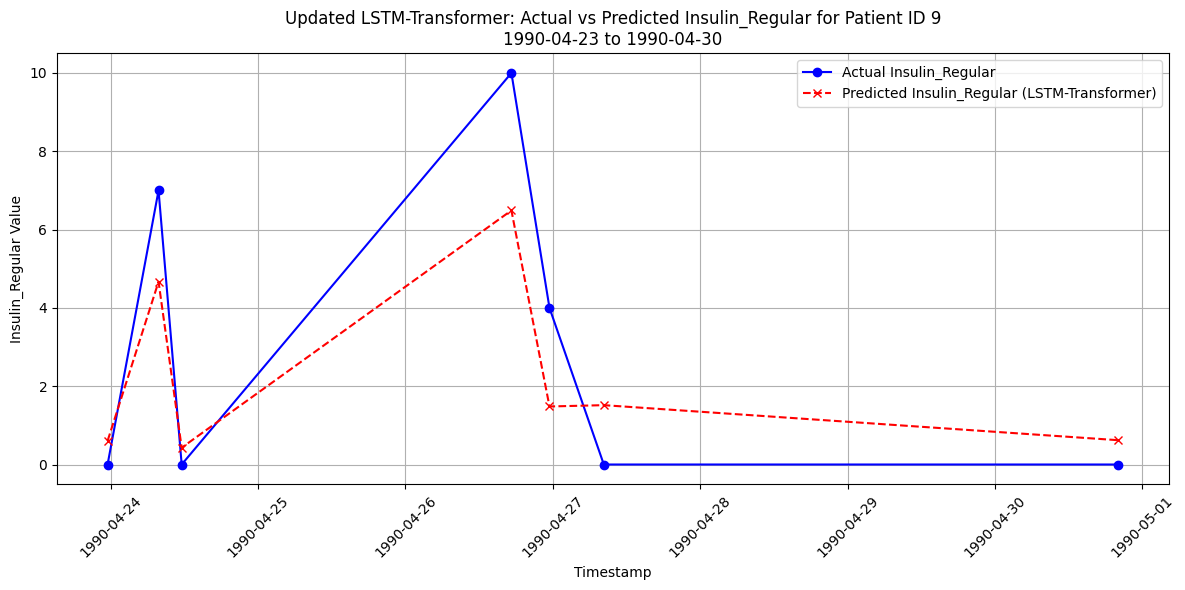

Plotted data for patient_id 9 from 1990-04-23 23:29:00 to 1990-04-30 23:29:00


In [ ]:
# Example: Plot for a patient
plot_actual_vs_predicted_one_week_lstm(patient_id_to_plot=9,
                                       patient_ids_test=patient_ids_test,
                                       timestamps_test=timestamps_test,
                                       y_test=y_test_unscaled,
                                       y_pred=y_pred_unscaled)

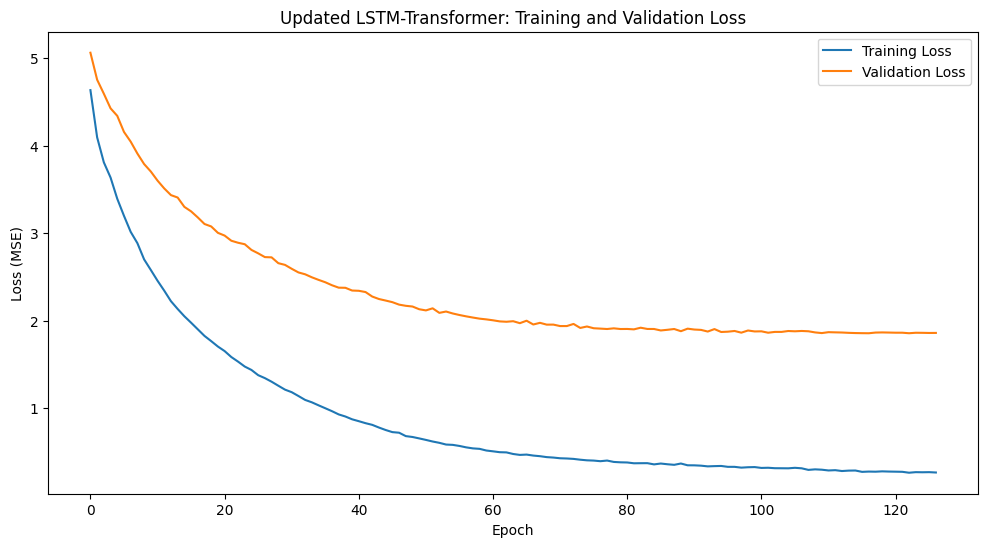

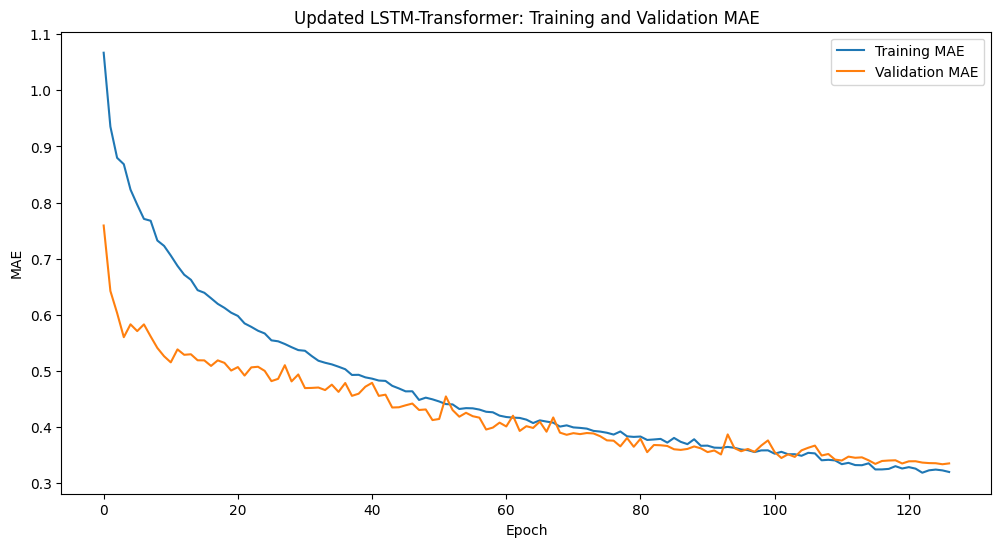

In [ ]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Updated LSTM-Transformer: Training and Validation Loss')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.title('Updated LSTM-Transformer: Training and Validation MAE')
plt.show()

In [ ]:
# Save model and history
model_dir = '/content/drive/MyDrive/MINI01/models/'
results_dir = '/content/drive/MyDrive/MINI01/results/'
os.makedirs(model_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

In [ ]:
model_path = os.path.join(model_dir, 'pp2_insulin_prediction_lstm_model_updated.h5')
lstm_transformer_model.save(model_path)
print(f"Model saved to {model_path}")

Model saved to /content/drive/MyDrive/MINI01/models/pp2_insulin_prediction_lstm_model_updated.h5


In [ ]:
history_df = pd.DataFrame(history.history)
history_path = os.path.join(results_dir, 'pp2_training_lstm_history_updated.csv')
history_df.to_csv(history_path, index=False)
print(f"Training history saved to {history_path}")

Training history saved to /content/drive/MyDrive/MINI01/results/pp2_training_lstm_history_updated.csv


#model02: GRU-transformer hybrid model ( 0.53 )

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, GRU, Dense, LayerNormalization, MultiHeadAttention, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

In [ ]:
# Define input shape
input_layer = Input(shape=(window_size, len(features)))

# GRU Layer
gru_output = GRU(128, return_sequences=True, kernel_regularizer=l2(0.01))(input_layer)
gru_output = LayerNormalization()(gru_output)  # Normalize GRU output

# Transformer Encoder
attention_output = MultiHeadAttention(num_heads=4, key_dim=128)(gru_output, gru_output)
attention_output = Dropout(0.3)(attention_output)
attention_output = LayerNormalization()(attention_output)

# Fully Connected Layer
dense_output = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(attention_output[:, -1, :])  # Take last timestep
dense_output = BatchNormalization()(dense_output)
dense_output = Dropout(0.3)(dense_output)

# Output Layer
output_layer = Dense(1)(dense_output)


In [ ]:
# Compile Model
gru_transformer_model = Model(inputs=input_layer, outputs=output_layer)
gru_transformer_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])

# Summary
gru_transformer_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 7, 5)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_4 (GRU)               │ (None, 7, 128)         │         51,840 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 7, 128)         │            256 │ gru_4[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_2    │ (None, 7, 128)         │        263,808 │ layer_normalization_2… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_14 (Dropout)      │ (None, 7, 128)         │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_3     │ (None, 7, 128)         │            256 │ dropout_14[0][0]       │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 128)            │              0 │ layer_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 64)             │          8,256 │ get_item[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_9     │ (None, 64)             │            256 │ dense_10[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_15 (Dropout)      │ (None, 64)             │              0 │ batch_normalization_9… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 1)              │             65 │ dropout_15[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 324,737 (1.24 MB)

 Trainable params: 324,609 (1.24 MB)

 Non-trainable params: 128 (512.00 B)

In [ ]:


# Training with Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
357/357 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.4023 - mae: 0.4357 - val_loss: 1.9078 - val_mae: 0.4412
Epoch 2/100
357/357 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.4227 - mae: 0.4486 - val_loss: 1.8816 - val_mae: 0.4259
Epoch 3/100
357/357 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.4339 - mae: 0.4383 - val_loss: 1.9182 - val_mae: 0.4418
Epoch 4/100
357/357 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.4000 - mae: 0.4373 - val_loss: 1.8890 - val_mae: 0.4177
Epoch 5/100
357/357 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.3943 - mae: 0.4358 - val_loss: 1.8867 - val_mae: 0.4130
Epoch 6/100
357/357 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.4030 - mae: 0.4365 - val_loss: 1.8826 - val_mae: 0.4065
Epoch 7/100
357/357 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.3973 - mae: 0.4346 - val_loss: 1.8718 - val_mae: 0.3943
Epoch 8/100
357/357 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.4160 - mae: 0.4372 - val_loss: 1.8714 - val_mae: 0.4101
Epoch 9/100
357/357 ━━━━━━━━━━━━━━━━━━━━ 5s 

In [ ]:
# Evaluate performance
y_pred_scaled = model.predict(X_test)
y_test_unscaled = scaler_target.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_unscaled = scaler_target.inverse_transform(y_pred_scaled).flatten()

r2 = r2_score(y_test_unscaled, y_pred_unscaled)
mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
mse = mean_squared_error(y_test_unscaled, y_pred_unscaled)

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [ ]:
print(f"GRU-Transformer Model Performance:")
print(f"R²: {r2:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")

GRU-Transformer Model Performance:
R²: 0.53
MAE: 1.84
MSE: 10.14


In [ ]:
def plot_actual_vs_predicted_one_week_gru(patient_id_to_plot, patient_ids_test, timestamps_test, y_test, y_pred):
    # Filter for the specified patient
    mask = patient_ids_test == patient_id_to_plot
    if not np.any(mask):
        print(f"No test data found for patient_id {patient_id_to_plot}")
        return

    patient_timestamps = timestamps_test[mask]
    patient_actual = y_test[mask]  # Already unscaled
    patient_predicted = y_pred[mask]  # Already unscaled

    # Automatically select the earliest date for the patient as the start_date
    start_date = patient_timestamps.min()
    end_date = start_date + timedelta(days=7)

    # Filter for the one-week span
    time_mask = (patient_timestamps >= start_date) & (patient_timestamps < end_date)
    if not np.any(time_mask):
        print(f"No test data found for patient_id {patient_id_to_plot} between {start_date} and {end_date}")
        return

    patient_timestamps = patient_timestamps[time_mask]
    patient_actual = patient_actual[time_mask]
    patient_predicted = patient_predicted[time_mask]

    # Sort by timestamp
    sorted_indices = np.argsort(patient_timestamps)
    patient_timestamps = patient_timestamps[sorted_indices]
    patient_actual = patient_actual[sorted_indices]
    patient_predicted = patient_predicted[sorted_indices]

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(patient_timestamps, patient_actual, label='Actual Insulin_Regular', color='blue', marker='o')
    plt.plot(patient_timestamps, patient_predicted, label='Predicted Insulin_Regular (GRU-Transformer)', color='red', linestyle='--', marker='x')
    plt.xlabel('Timestamp')
    plt.ylabel('Insulin_Regular Value')
    plt.title(f'GRU-Transformer: Actual vs Predicted Insulin_Regular for Patient ID {patient_id_to_plot}\n{start_date.date()} to {end_date.date()}')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Print the selected date range
    print(f"Plotted data for patient_id {patient_id_to_plot} from {start_date} to {end_date}")


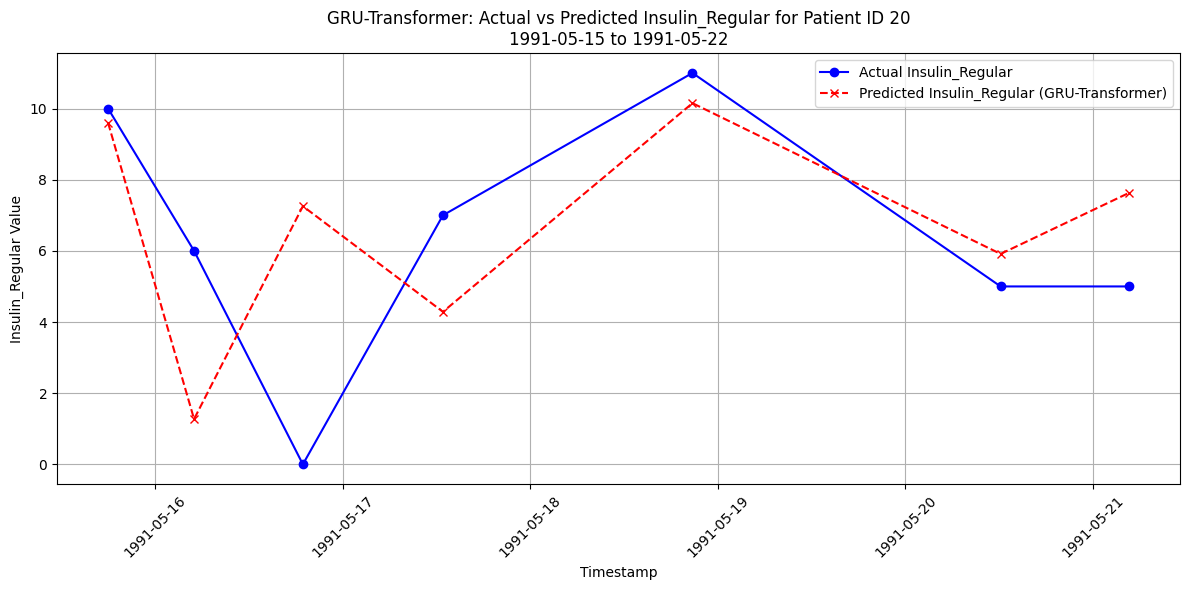

Plotted data for patient_id 20 from 1991-05-15 18:00:00 to 1991-05-22 18:00:00


In [ ]:
# Example: Plot for a patient using the GRU-Transformer model
plot_actual_vs_predicted_one_week_gru(patient_id_to_plot=20,
                                      patient_ids_test=patient_ids_test,
                                      timestamps_test=timestamps_test,
                                      y_test=y_test_unscaled,  # Unscaled test values
                                      y_pred=y_pred_unscaled)  # Unscaled predicted values

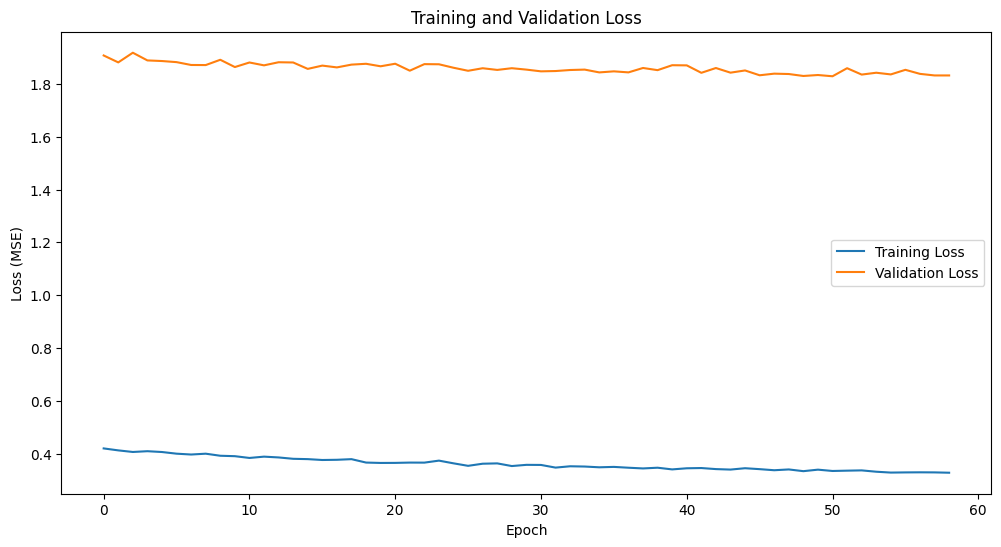

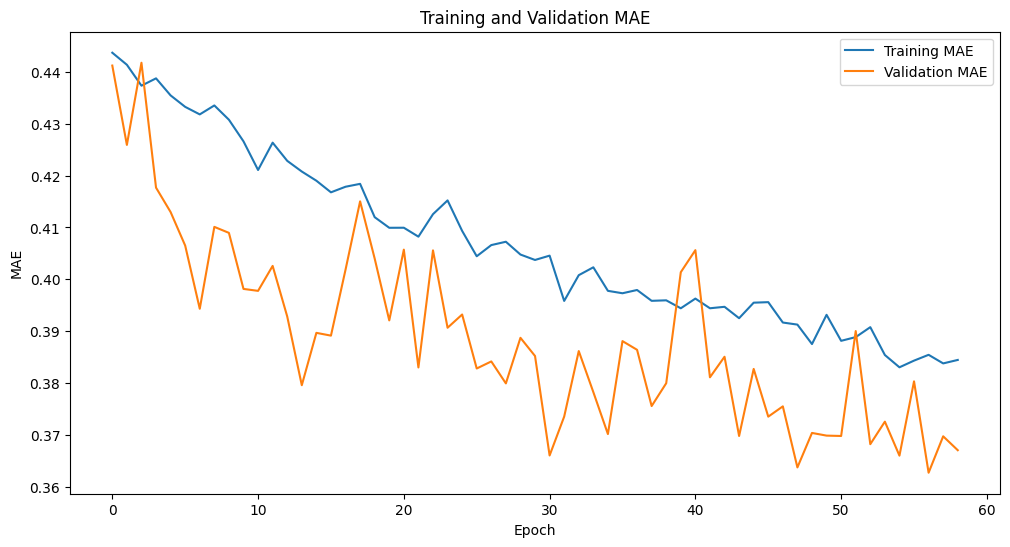

In [ ]:
# Optional: Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.title('Training and Validation MAE')
plt.show()

In [ ]:
import os
model_dir = '/content/drive/MyDrive/MINI01/models/'
results_dir = '/content/drive/MyDrive/MINI01/results/'
os.makedirs(model_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

In [ ]:
model_path = os.path.join(model_dir, 'pp2_insulin_prediction_gru_model.h5')
model.save(model_path)
print(f"Model saved to {model_path}")

Model saved to /content/drive/MyDrive/MINI01/models/pp2_insulin_prediction_gru_model.h5


In [ ]:
history_df = pd.DataFrame(history.history)
history_path = os.path.join(results_dir, 'pp2_training_gru_history.csv')
history_df.to_csv(history_path, index=False)
print(f"Training history saved to {history_path}")

Training history saved to /content/drive/MyDrive/MINI01/results/pp2_training_gru_history.csv


# Final : LSTM-GRU model (0.62)

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from datetime import timedelta
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [ ]:
# Define paths
model_dir = '/content/drive/MyDrive/MINI01/pp2_models/'
results_dir = '/content/drive/MyDrive/MINI01/pp2_results/'
os.makedirs(model_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

In [ ]:
# Define model
model = Sequential([
    LSTM(256, input_shape=(window_size, len(features)), return_sequences=True, kernel_regularizer=l2(0.003)),
    BatchNormalization(),
    Dropout(0.3),

    GRU(128, return_sequences=False, kernel_regularizer=l2(0.003)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='relu', kernel_regularizer=l2(0.003)),
    BatchNormalization(),
    Dropout(0.2),

    Dense(64, activation='relu', kernel_regularizer=l2(0.003)),
    BatchNormalization(),
    Dropout(0.2),

    Dense(1)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Optimizer and Learning Rate Scheduling
optimizer = Adam(learning_rate=0.0005)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

# Compile model
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

In [ ]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# Train model
history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Epoch 1/200
179/179 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 3.8495 - mae: 1.1854 - val_loss: 3.6816 - val_mae: 0.6625 - learning_rate: 5.0000e-04
Epoch 2/200
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.6113 - mae: 0.8520 - val_loss: 3.5036 - val_mae: 0.6442 - learning_rate: 5.0000e-04
Epoch 3/200
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 2.2610 - mae: 0.7595 - val_loss: 3.3248 - val_mae: 0.6155 - learning_rate: 5.0000e-04
Epoch 4/200
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 2.0463 - mae: 0.7205 - val_loss: 3.2069 - val_mae: 0.5817 - learning_rate: 5.0000e-04
Epoch 5/200
179/179 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 1.8778 - mae: 0.6818 - val_loss: 3.0893 - val_mae: 0.5710 - learning_rate: 5.0000e-04
Epoch 6/200
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 1.6846 - mae: 0.6356 - val_loss: 2.9859 - val_mae: 0.5486 - learning_rate: 5.0000e-04
Epoch 7/200
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1.5629 - mae: 0.6128 - val_loss: 2.8995 - val_mae:

In [ ]:
# Predictions
y_pred_scaled = model.predict(X_test)
y_test_unscaled = scaler_target.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_unscaled = scaler_target.inverse_transform(y_pred_scaled).flatten()

# Evaluate
r2 = r2_score(y_test_unscaled, y_pred_unscaled)
mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
mse = mean_squared_error(y_test_unscaled, y_pred_unscaled)

112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [ ]:
# Compute MASE
y_naive = y_test_unscaled[:-1]
y_true_naive = y_test_unscaled[1:]
mae_naive = mean_absolute_error(y_true_naive, y_naive)
mase = mae / mae_naive if mae_naive != 0 else np.inf

print(f"R²: {r2:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"MASE: {mase:.2f}")

R²: 0.62
MAE: 1.43
MSE: 8.29
MASE: 0.32


In [ ]:
# Save Model and Training History
model_path = os.path.join(model_dir, 'pp2_optimized_model.h5')
model.save(model_path)
print(f"Model saved to {model_path}")

history_df = pd.DataFrame(history.history)
history_path = os.path.join(results_dir, 'pp2_training_history.csv')
history_df.to_csv(history_path, index=False)
print(f"Training history saved to {history_path}")

Model saved to /content/drive/MyDrive/MINI01/pp2_models/pp2_optimized_model.h5
Training history saved to /content/drive/MyDrive/MINI01/pp2_results/pp2_training_history.csv


In [ ]:
# Plot Actual vs Predicted
def plot_actual_vs_predicted_one_week(patient_id_to_plot, patient_ids_test, timestamps_test, y_test, y_pred):
    mask = patient_ids_test == patient_id_to_plot
    if not np.any(mask):
        print(f"No test data found for patient_id {patient_id_to_plot}")
        return

    patient_timestamps = timestamps_test[mask]
    patient_actual = y_test[mask]
    patient_predicted = y_pred[mask]

    start_date = patient_timestamps.min()
    end_date = start_date + timedelta(days=7)

    time_mask = (patient_timestamps >= start_date) & (patient_timestamps < end_date)
    if not np.any(time_mask):
        print(f"No test data found for patient_id {patient_id_to_plot} between {start_date} and {end_date}")
        return

    patient_timestamps = patient_timestamps[time_mask]
    patient_actual = patient_actual[time_mask]
    patient_predicted = patient_predicted[time_mask]

    sorted_indices = np.argsort(patient_timestamps)
    patient_timestamps = patient_timestamps[sorted_indices]
    patient_actual = patient_actual[sorted_indices]
    patient_predicted = patient_predicted[sorted_indices]

    plt.figure(figsize=(12, 6))
    plt.plot(patient_timestamps, patient_actual, label='Actual Insulin_Regular', color='blue', marker='o')
    plt.plot(patient_timestamps, patient_predicted, label='Predicted Insulin_Regular', color='red', linestyle='--', marker='x')
    plt.xlabel('Timestamp')
    plt.ylabel('Insulin_Regular Value')
    plt.title(f'Actual vs Predicted Insulin_Regular for Patient ID {patient_id_to_plot}\n{start_date.date()} to {end_date.date()}')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    print(f"Plotted data for patient_id {patient_id_to_plot} from {start_date} to {end_date}")


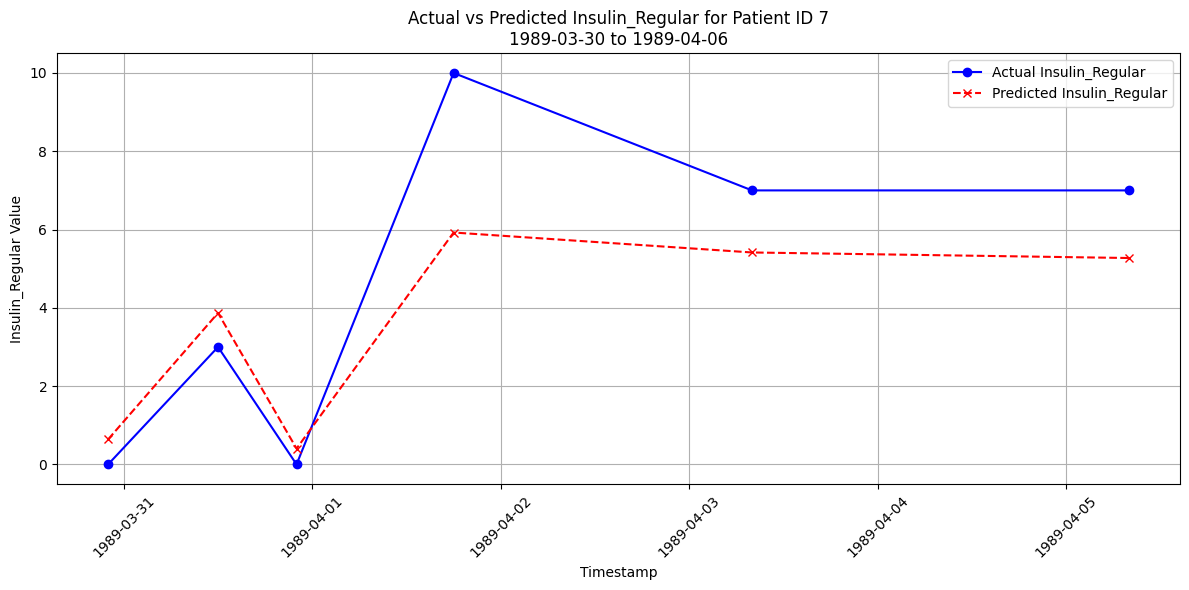

Plotted data for patient_id 7 from 1989-03-30 22:00:00 to 1989-04-06 22:00:00


In [ ]:
# Example: Plot for patient_id 7
plot_actual_vs_predicted_one_week(
    patient_id_to_plot=7,
    patient_ids_test=patient_ids_test,
    timestamps_test=timestamps_test,
    y_test=y_test_unscaled,
    y_pred=y_pred_unscaled
)


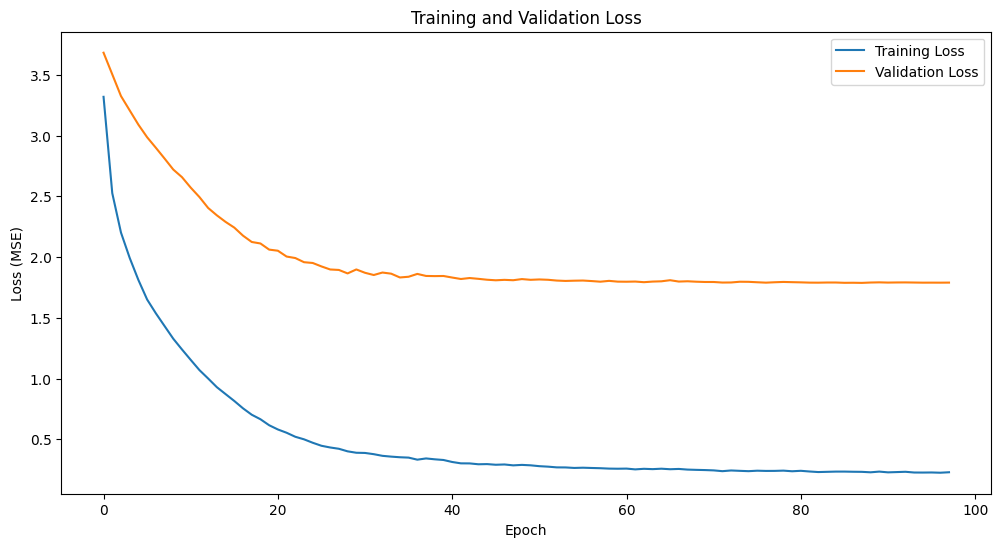

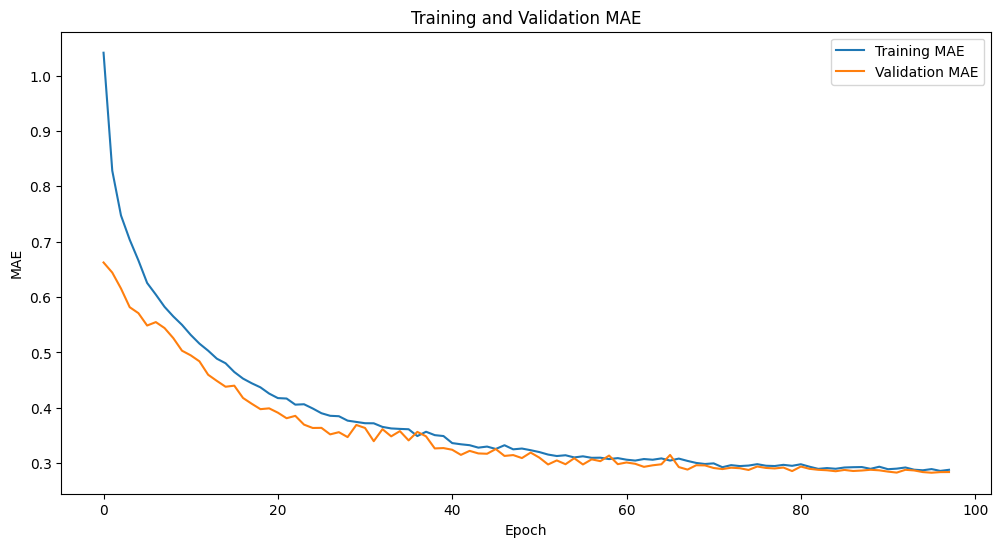

In [ ]:
# Plot Training Loss and MAE
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.title('Training and Validation MAE')
plt.show()

# 12April

In [ ]:
#mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, LayerNormalization, MultiHeadAttention, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/MINI01/processed-diabetes-data/combined_data.csv')
data['Value'] = pd.to_numeric(data['Value'], errors='coerce').fillna(0)
data['datetime'] = pd.to_datetime(data['datetime'])

glucose_codes = [48, 57, 58, 59, 60, 61, 62, 63, 64]
long_acting_codes = [34, 35]

<ipython-input-55-01cccd3c7f4b>:3: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data['datetime'] = pd.to_datetime(data['datetime'])


In [ ]:
pivoted_data = data.pivot_table(index=['patient_id', 'datetime'],
                                columns='Code', values='Value',
                                aggfunc='first').reset_index().fillna(0)

pivoted_data['Glucose'] = pivoted_data[glucose_codes].max(axis=1)
pivoted_data['Insulin_LongActing'] = pivoted_data[long_acting_codes].max(axis=1)
pivoted_data['Insulin_Regular'] = pivoted_data.get(33, 0)
pivoted_data['Hypoglycemia'] = pivoted_data.get(65, 0).apply(lambda x: 1 if x > 0 else 0)


In [ ]:
# Drop unnecessary columns
pivoted_data = pivoted_data.drop(columns=[col for col in pivoted_data.columns if isinstance(col, (int, float))])
pivoted_data = pivoted_data.sort_values(['patient_id', 'datetime'])

# Enhanced feature engineering
pivoted_data['Hour'] = pivoted_data['datetime'].dt.hour
pivoted_data['Minute'] = pivoted_data['datetime'].dt.minute
pivoted_data['DayOfWeek'] = pivoted_data['datetime'].dt.dayofweek
pivoted_data['Glucose'] = pivoted_data.groupby('patient_id')['Glucose'].transform(lambda x: x.replace(0, np.nan).ffill())
pivoted_data['Glucose'] = pivoted_data['Glucose'].fillna(pivoted_data['Glucose'].mean())

# Clip outliers
pivoted_data['Glucose'] = pivoted_data['Glucose'].clip(upper=500)  # Cap extreme glucose values
pivoted_data['Insulin_Regular'] = pivoted_data['Insulin_Regular'].clip(upper=100)  # Cap extreme insulin doses

In [ ]:
# Lag and rolling features
for lag in [1, 2, 3]:
    pivoted_data[f'Glucose_Lag{lag}'] = pivoted_data.groupby('patient_id')['Glucose'].shift(lag)
    pivoted_data[f'Insulin_Regular_Lag{lag}'] = pivoted_data.groupby('patient_id')['Insulin_Regular'].shift(lag)
pivoted_data['Glucose_RollingMean'] = pivoted_data.groupby('patient_id')['Glucose'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
pivoted_data['Glucose_RollingStd'] = pivoted_data.groupby('patient_id')['Glucose'].transform(lambda x: x.rolling(window=3, min_periods=1).std())
pivoted_data['Glucose_Insulin_Interaction'] = pivoted_data['Glucose'] * pivoted_data['Insulin_Regular']  # New interaction term
pivoted_data = pivoted_data.fillna(0)

pivoted_data_with_time = pivoted_data.copy()
pivoted_data = pivoted_data.drop(columns=['datetime'])

In [ ]:
# Feature list
features = ['Hour', 'Minute', 'DayOfWeek', 'Glucose', 'Insulin_LongActing', 'Hypoglycemia',
            'Glucose_Lag1', 'Glucose_Lag2', 'Glucose_Lag3',
            'Insulin_Regular_Lag1', 'Insulin_Regular_Lag2', 'Insulin_Regular_Lag3',
            'Glucose_RollingMean', 'Glucose_RollingStd', 'Glucose_Insulin_Interaction']
target = 'Insulin_Regular'
window_size = 10

In [ ]:
# Prepare sequences
X, y, patient_ids, timestamps = [], [], [], []

for patient in pivoted_data['patient_id'].unique():
    patient_data = pivoted_data[pivoted_data['patient_id'] == patient].copy()
    patient_data_with_time = pivoted_data_with_time[pivoted_data_with_time['patient_id'] == patient].copy()

    if len(patient_data) < window_size + 1:
        continue

    for i in range(len(patient_data) - window_size):
        X.append(patient_data[features].iloc[i:i+window_size].values)
        y.append(patient_data[target].iloc[i+window_size])
        patient_ids.append(patient)
        timestamps.append(patient_data_with_time['datetime'].iloc[i+window_size])

In [ ]:
X = np.array(X)
y = np.array(y)
patient_ids = np.array(patient_ids)
timestamps = np.array(timestamps)

In [ ]:
# Scaling
scaler_features = StandardScaler()
X_scaled = scaler_features.fit_transform(X.reshape(-1, len(features))).reshape(X.shape)
# Scaling
scaler_features = StandardScaler()
X_scaled = scaler_features.fit_transform(X.reshape(-1, len(features))).reshape(X.shape)

scaler_target = StandardScaler()
y_scaled = scaler_target.fit_transform(y.reshape(-1, 1)).flatten()

In [ ]:
# Train-test split
X_temp, X_test, y_temp, y_test, patient_ids_temp, patient_ids_test, timestamps_temp, timestamps_test = train_test_split(
    X_scaled, y_scaled, patient_ids, timestamps, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

In [ ]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.3):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim)
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=None):  # Explicitly define training argument
        attn_output = self.att(inputs, inputs, training=training)  # Pass training to MultiHeadAttention
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [ ]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, sequence_length, embed_dim):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(sequence_length, embed_dim)

    def get_angles(self, pos, i, embed_dim):
        angles = pos / tf.pow(10000.0, (2 * (i // 2)) / tf.cast(embed_dim, tf.float32))
        return angles

    def positional_encoding(self, sequence_length, embed_dim):
        angle_rads = self.get_angles(
            pos=tf.range(sequence_length, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(embed_dim, dtype=tf.float32)[tf.newaxis, :],
            embed_dim=embed_dim)
        sines = tf.math.sin(angle_rads[:, 0::2])
        cosines = tf.math.cos(angle_rads[:, 1::2])
        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding

In [ ]:
def build_transformer_model(input_shape, embed_dim=64, num_heads=4, ff_dim=128):
    inputs = Input(shape=input_shape)

    # Lightweight LSTM
    x = LSTM(32, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001))(inputs)  # Reduced units

    # Project to embed_dim
    x = Dense(embed_dim)(x)

    # Positional encoding
    x = PositionalEncoding(sequence_length=input_shape[0], embed_dim=embed_dim)(x)

    # Transformer block
    x = TransformerBlock(embed_dim, num_heads, ff_dim)(x, training=True)  # Explicit training flag during model building

    # Global average pooling
    x = tf.keras.layers.GlobalAveragePooling1D()(x)

    # Dense layers
    x = Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)  # Reduced units
    x = Dropout(0.4)(x)  # Increased dropout
    x = Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = Dropout(0.4)(x)
    outputs = Dense(1)(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
model = build_transformer_model(input_shape=(window_size, len(features)))

# Training (unchanged)
optimizer = Adam(learning_rate=0.0005, clipnorm=1.0)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)

model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/100
353/353 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 1.0283 - mae: 0.7392 - val_loss: 0.8697 - val_mae: 0.6238 - learning_rate: 5.0000e-04
Epoch 2/100
353/353 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.8004 - mae: 0.6494 - val_loss: 0.8485 - val_mae: 0.6332 - learning_rate: 5.0000e-04
Epoch 3/100
353/353 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.7521 - mae: 0.6339 - val_loss: 0.8184 - val_mae: 0.6259 - learning_rate: 5.0000e-04
Epoch 4/100
353/353 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.7270 - mae: 0.6095 - val_loss: 0.7784 - val_mae: 0.5899 - learning_rate: 5.0000e-04
Epoch 5/100
353/353 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.6827 - mae: 0.5902 - val_loss: 0.7824 - val_mae: 0.5754 - learning_rate: 5.0000e-04
Epoch 6/100
353/353 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.6775 - mae: 0.5829 - val_loss: 0.7874 - val_mae: 0.6020 - learning_rate: 5.0000e-04
Epoch 7/100
353/353 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.6416 - mae: 0.5653 - val_loss: 0.6535 - val_ma

In [ ]:
y_pred_scaled = model.predict(X_test)
y_test_unscaled = scaler_target.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_unscaled = scaler_target.inverse_transform(y_pred_scaled).flatten()

r2 = r2_score(y_test_unscaled, y_pred_unscaled)
mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
mse = mean_squared_error(y_test_unscaled, y_pred_unscaled)
mae_naive = mean_absolute_error(y_test_unscaled[1:], y_test_unscaled[:-1])
mase = mae / mae_naive if mae_naive != 0 else np.inf


111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [ ]:
print(f"R²: {r2:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"MASE: {mase:.2f}")

R²: 0.74
MAE: 1.49
MSE: 4.89
MASE: 0.34


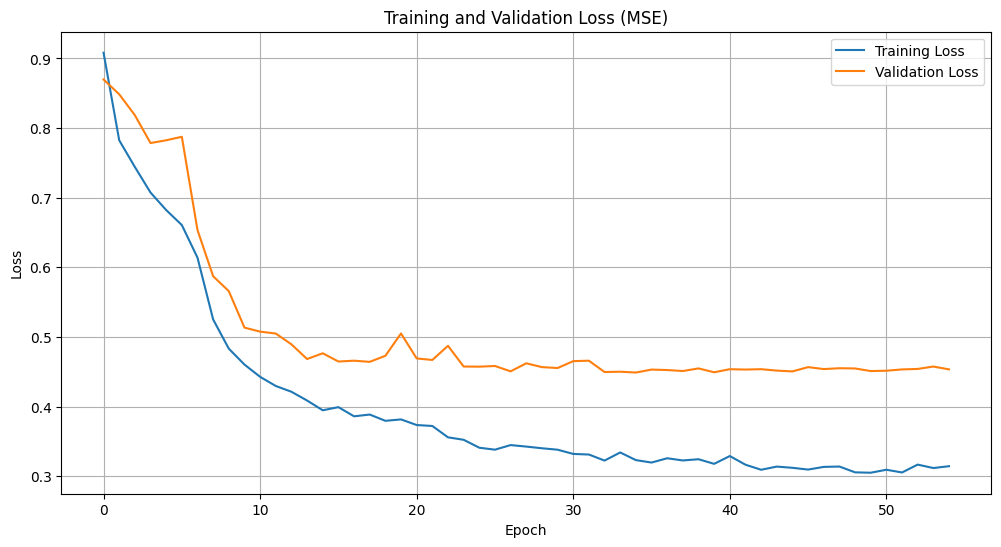

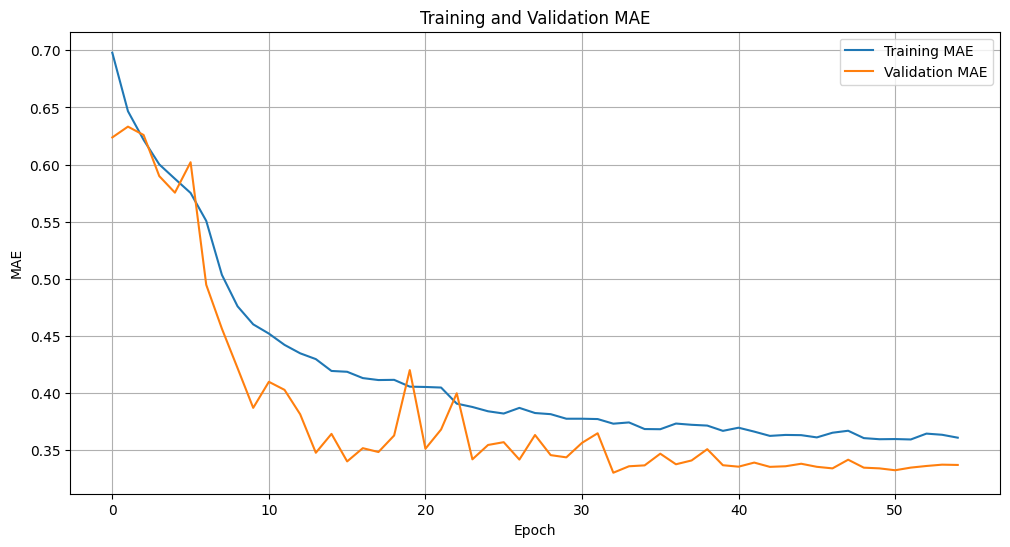

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Define paths
model_dir = '/content/drive/MyDrive/MINI01/pp2_models/'
results_dir = '/content/drive/MyDrive/MINI01/pp2_results/'
os.makedirs(model_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

In [ ]:
# Define paths
model_dir = '/content/drive/MyDrive/MINI01/pp2_models/'
os.makedirs(model_dir, exist_ok=True)

# Save the model in .h5 format
model_save_path = os.path.join(model_dir, 'insulin_transformer_model.h5')
model.save(model_save_path, save_format='h5')

# Save weights separately (optional, for checkpointing)
model.save_weights(os.path.join(model_dir, 'insulin_transformer_model_weights.weights.h5')) # Added .weights to the filename before .h5


In [ ]:
# Plot Actual vs Predicted
def plot_actual_vs_predicted_one_week(patient_id_to_plot, patient_ids_test, timestamps_test, y_test, y_pred):
    mask = patient_ids_test == patient_id_to_plot
    if not np.any(mask):
        print(f"No test data found for patient_id {patient_id_to_plot}")
        return

    patient_timestamps = timestamps_test[mask]
    patient_actual = y_test[mask]
    patient_predicted = y_pred[mask]

    start_date = patient_timestamps.min()
    end_date = start_date + timedelta(days=7)

    time_mask = (patient_timestamps >= start_date) & (patient_timestamps < end_date)
    if not np.any(time_mask):
        print(f"No test data found for patient_id {patient_id_to_plot} between {start_date} and {end_date}")
        return

    patient_timestamps = patient_timestamps[time_mask]
    patient_actual = patient_actual[time_mask]
    patient_predicted = patient_predicted[time_mask]

    sorted_indices = np.argsort(patient_timestamps)
    patient_timestamps = patient_timestamps[sorted_indices]
    patient_actual = patient_actual[sorted_indices]
    patient_predicted = patient_predicted[sorted_indices]

    plt.figure(figsize=(12, 6))
    plt.plot(patient_timestamps, patient_actual, label='Actual Insulin_Regular', color='blue', marker='o')
    plt.plot(patient_timestamps, patient_predicted, label='Predicted Insulin_Regular', color='red', linestyle='--', marker='x')
    plt.xlabel('Timestamp')
    plt.ylabel('Insulin_Regular Value')
    plt.title(f'Actual vs Predicted Insulin_Regular for Patient ID {patient_id_to_plot}\n{start_date.date()} to {end_date.date()}')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Save the plot
    plot_save_path = os.path.join(results_dir, f'actual_vs_predicted_patient_{patient_id_to_plot}.png')
    plt.savefig(plot_save_path)
    plt.show()

    print(f"Plotted data for patient_id {patient_id_to_plot} from {start_date} to {end_date}")

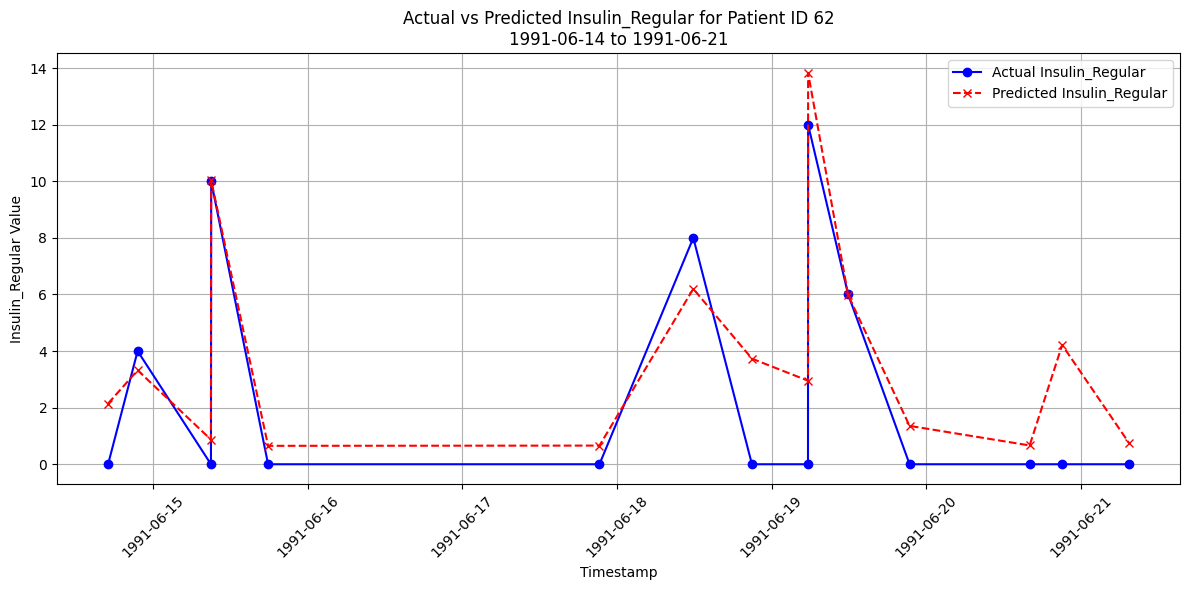

Plotted data for patient_id 62 from 1991-06-14 17:01:00 to 1991-06-21 17:01:00


In [ ]:
# Example: Plot for patient_id 7
plot_actual_vs_predicted_one_week(
    patient_id_to_plot=62,
    patient_ids_test=patient_ids_test,
    timestamps_test=timestamps_test,
    y_test=y_test_unscaled,
    y_pred=y_pred_unscaled
)

# New tranformer : LSTM+GRU

In [ ]:
#mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, LayerNormalization, MultiHeadAttention, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
import pickle
import json
import os
from datetime import timedelta

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/MINI01/processed-diabetes-data/combined_data.csv')
data['Value'] = pd.to_numeric(data['Value'], errors='coerce').fillna(0)
data['datetime'] = pd.to_datetime(data['datetime'])

glucose_codes = [48, 57, 58, 59, 60, 61, 62, 63, 64]
long_acting_codes = [34, 35]

<ipython-input-3-01cccd3c7f4b>:3: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data['datetime'] = pd.to_datetime(data['datetime'])


In [ ]:
pivoted_data = data.pivot_table(index=['patient_id', 'datetime'],
                                columns='Code', values='Value',
                                aggfunc='first').reset_index().fillna(0)

pivoted_data['Glucose'] = pivoted_data[glucose_codes].max(axis=1)
pivoted_data['Insulin_LongActing'] = pivoted_data[long_acting_codes].max(axis=1)
pivoted_data['Insulin_Regular'] = pivoted_data.get(33, 0)
pivoted_data['Hypoglycemia'] = pivoted_data.get(65, 0).apply(lambda x: 1 if x > 0 else 0)


In [ ]:
# Drop unnecessary columns
pivoted_data = pivoted_data.drop(columns=[col for col in pivoted_data.columns if isinstance(col, (int, float))])
pivoted_data = pivoted_data.sort_values(['patient_id', 'datetime'])

# Enhanced feature engineering
pivoted_data['Hour'] = pivoted_data['datetime'].dt.hour
pivoted_data['Minute'] = pivoted_data['datetime'].dt.minute
pivoted_data['DayOfWeek'] = pivoted_data['datetime'].dt.dayofweek
pivoted_data['Glucose'] = pivoted_data.groupby('patient_id')['Glucose'].transform(lambda x: x.replace(0, np.nan).ffill())
pivoted_data['Glucose'] = pivoted_data['Glucose'].fillna(pivoted_data['Glucose'].mean())

# Clip outliers
pivoted_data['Glucose'] = pivoted_data['Glucose'].clip(upper=500)  # Cap extreme glucose values
pivoted_data['Insulin_Regular'] = pivoted_data['Insulin_Regular'].clip(upper=100)  # Cap extreme insulin doses

In [ ]:
# Lag and rolling features
for lag in [1, 2, 3]:
    pivoted_data[f'Glucose_Lag{lag}'] = pivoted_data.groupby('patient_id')['Glucose'].shift(lag)
    pivoted_data[f'Insulin_Regular_Lag{lag}'] = pivoted_data.groupby('patient_id')['Insulin_Regular'].shift(lag)
pivoted_data['Glucose_RollingMean'] = pivoted_data.groupby('patient_id')['Glucose'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
pivoted_data['Glucose_RollingStd'] = pivoted_data.groupby('patient_id')['Glucose'].transform(lambda x: x.rolling(window=3, min_periods=1).std())
pivoted_data['Glucose_Insulin_Interaction'] = pivoted_data['Glucose'] * pivoted_data['Insulin_Regular']  # New interaction term
pivoted_data = pivoted_data.fillna(0)

pivoted_data_with_time = pivoted_data.copy()
pivoted_data = pivoted_data.drop(columns=['datetime'])

In [ ]:
# Feature list
features = ['Hour', 'Minute', 'DayOfWeek', 'Glucose', 'Insulin_LongActing', 'Hypoglycemia',
            'Glucose_Lag1', 'Glucose_Lag2', 'Glucose_Lag3',
            'Insulin_Regular_Lag1', 'Insulin_Regular_Lag2', 'Insulin_Regular_Lag3',
            'Glucose_RollingMean', 'Glucose_RollingStd', 'Glucose_Insulin_Interaction']
target = 'Insulin_Regular'
window_size = 10

In [ ]:
# Prepare sequences
X, y, patient_ids, timestamps = [], [], [], []

for patient in pivoted_data['patient_id'].unique():
    patient_data = pivoted_data[pivoted_data['patient_id'] == patient].copy()
    patient_data_with_time = pivoted_data_with_time[pivoted_data_with_time['patient_id'] == patient].copy()

    if len(patient_data) < window_size + 1:
        continue

    for i in range(len(patient_data) - window_size):
        X.append(patient_data[features].iloc[i:i+window_size].values)
        y.append(patient_data[target].iloc[i+window_size])
        patient_ids.append(patient)
        timestamps.append(patient_data_with_time['datetime'].iloc[i+window_size])

In [ ]:
X = np.array(X)
y = np.array(y)
patient_ids = np.array(patient_ids)
timestamps = np.array(timestamps)

In [ ]:
# Scaling
scaler_features = StandardScaler()
X_scaled = scaler_features.fit_transform(X.reshape(-1, len(features))).reshape(X.shape)
# Scaling
scaler_features = StandardScaler()
X_scaled = scaler_features.fit_transform(X.reshape(-1, len(features))).reshape(X.shape)

scaler_target = StandardScaler()
y_scaled = scaler_target.fit_transform(y.reshape(-1, 1)).flatten()

In [ ]:
# Train-test split
X_temp, X_test, y_temp, y_test, patient_ids_temp, patient_ids_test, timestamps_temp, timestamps_test = train_test_split(
    X_scaled, y_scaled, patient_ids, timestamps, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

In [ ]:
model_dir = '/content/drive/MyDrive/MINI01/pp2_models/'
results_dir = '/content/drive/MyDrive/MINI01/pp2_results/'
os.makedirs(model_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

In [ ]:
# Transformer block (unchanged)
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.3):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim)
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=None):
        attn_output = self.att(inputs, inputs, training=training)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [ ]:
# Positional encoding (unchanged)
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, sequence_length, embed_dim):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(sequence_length, embed_dim)

    def get_angles(self, pos, i, embed_dim):
        angles = pos / tf.pow(10000.0, (2 * (i // 2)) / tf.cast(embed_dim, tf.float32))
        return angles

    def positional_encoding(self, sequence_length, embed_dim):
        angle_rads = self.get_angles(
            pos=tf.range(sequence_length, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(embed_dim, dtype=tf.float32)[tf.newaxis, :],
            embed_dim=embed_dim)
        sines = tf.math.sin(angle_rads[:, 0::2])
        cosines = tf.math.cos(angle_rads[:, 1::2])
        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding

In [ ]:
def build_lstm_gru_transformer_model(input_shape, embed_dim=32, num_heads=2, ff_dim=64):
    inputs = Input(shape=input_shape)

    # LSTM layer
    x = LSTM(64, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001))(inputs)
    x = Dropout(0.3)(x)

    # GRU layer
    x = GRU(32, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = Dropout(0.3)(x)

    # Project to embed_dim for Transformer
    x = Dense(embed_dim)(x)

    # Positional encoding
    x = PositionalEncoding(sequence_length=input_shape[0], embed_dim=embed_dim)(x)

    # Transformer block
    x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)

    # Global average pooling
    x = tf.keras.layers.GlobalAveragePooling1D()(x)

    # Dense layers
    x = Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = Dropout(0.4)(x)
    x = Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = Dropout(0.4)(x)
    outputs = Dense(1)(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
model = build_lstm_gru_transformer_model(input_shape=(window_size, len(features)))

# Training
optimizer = Adam(learning_rate=0.0003, clipnorm=1.0)  # Lowered learning rate for stability
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True, verbose=1)

model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=100,  # Increased for potential convergence
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/100
353/353 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - loss: 1.0580 - mae: 0.7507 - val_loss: 0.9024 - val_mae: 0.6226 - learning_rate: 3.0000e-04
Epoch 2/100
353/353 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.8198 - mae: 0.6536 - val_loss: 0.8794 - val_mae: 0.6073 - learning_rate: 3.0000e-04
Epoch 3/100
353/353 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.8090 - mae: 0.6364 - val_loss: 0.8805 - val_mae: 0.6125 - learning_rate: 3.0000e-04
Epoch 4/100
353/353 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.7383 - mae: 0.6047 - val_loss: 0.8009 - val_mae: 0.5468 - learning_rate: 3.0000e-04
Epoch 5/100
353/353 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 0.7211 - mae: 0.5955 - val_loss: 0.8218 - val_mae: 0.5785 - learning_rate: 3.0000e-04
Epoch 6/100
353/353 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.6888 - mae: 0.5859 - val_loss: 0.8186 - val_mae: 0.5826 - learning_rate: 3.0000e-04
Epoch 7/100
353/353 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.6675 - mae: 0.5776 - val_loss: 0.7831 - val_m

In [ ]:
# Evaluation
y_pred_scaled = model.predict(X_test)
y_test_unscaled = scaler_target.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_unscaled = scaler_target.inverse_transform(y_pred_scaled).flatten()

r2 = r2_score(y_test_unscaled, y_pred_unscaled)
mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
mse = mean_squared_error(y_test_unscaled, y_pred_unscaled)
mae_naive = mean_absolute_error(y_test_unscaled[1:], y_test_unscaled[:-1])
mase = mae / mae_naive if mae_naive != 0 else np.inf

111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [ ]:
print(f"R²: {r2:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"MASE: {mase:.2f}")

R²: 0.75
MAE: 1.38
MSE: 4.80
MASE: 0.31


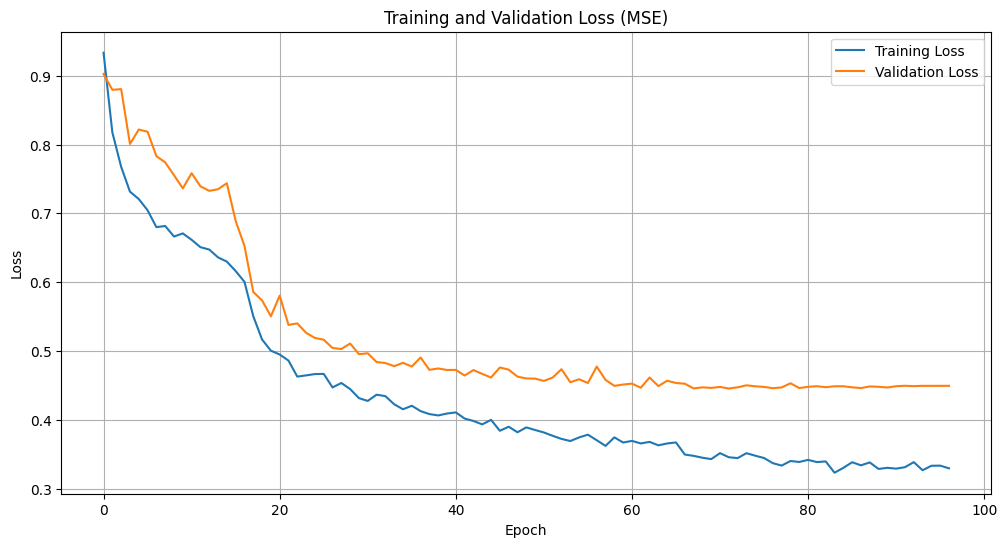

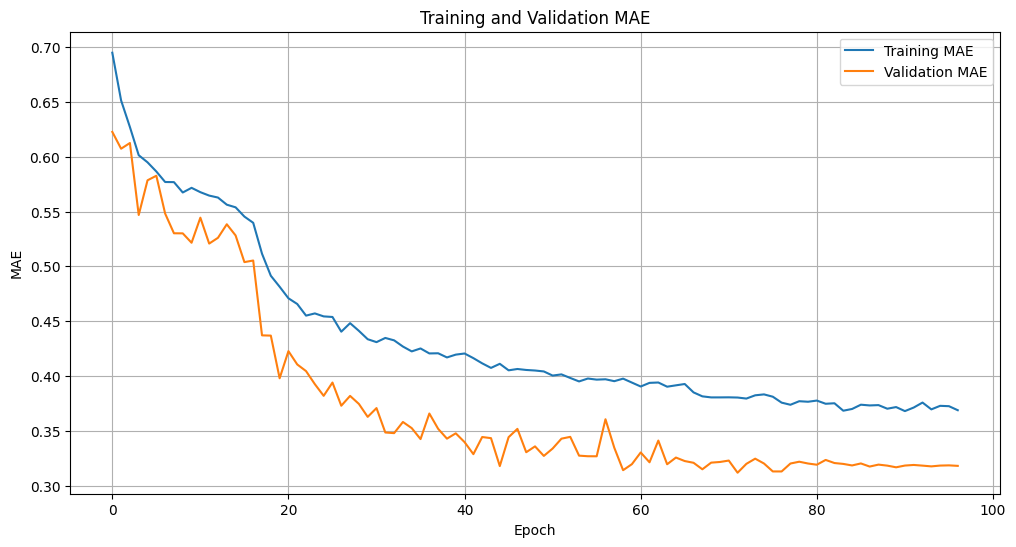

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(results_dir, 'loss_plot.png'))
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(results_dir, 'mae_plot.png'))
plt.show()

In [ ]:
# Plot Actual vs Predicted (unchanged)
def plot_actual_vs_predicted_one_week(patient_id_to_plot, patient_ids_test, timestamps_test, y_test, y_pred):
    mask = patient_ids_test == patient_id_to_plot
    if not np.any(mask):
        print(f"No test data found for patient_id {patient_id_to_plot}")
        return

    patient_timestamps = timestamps_test[mask]
    patient_actual = y_test[mask]
    patient_predicted = y_pred[mask]

    start_date = patient_timestamps.min()
    end_date = start_date + timedelta(days=7)

    time_mask = (patient_timestamps >= start_date) & (patient_timestamps < end_date)
    if not np.any(time_mask):
        print(f"No test data found for patient_id {patient_id_to_plot} between {start_date} and {end_date}")
        return

    patient_timestamps = patient_timestamps[time_mask]
    patient_actual = patient_actual[time_mask]
    patient_predicted = patient_predicted[time_mask]

    sorted_indices = np.argsort(patient_timestamps)
    patient_timestamps = patient_timestamps[sorted_indices]
    patient_actual = patient_actual[sorted_indices]
    patient_predicted = patient_predicted[sorted_indices]

    plt.figure(figsize=(12, 6))
    plt.plot(patient_timestamps, patient_actual, label='Actual Insulin_Regular', color='blue', marker='o')
    plt.plot(patient_timestamps, patient_predicted, label='Predicted Insulin_Regular', color='red', linestyle='--', marker='x')
    plt.xlabel('Timestamp')
    plt.ylabel('Insulin_Regular Value')
    plt.title(f'Actual vs Predicted Insulin_Regular for Patient ID {patient_id_to_plot}\n{start_date.date()} to {end_date.date()}')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()

    plot_save_path = os.path.join(results_dir, f'actual_vs_predicted_patient_{patient_id_to_plot}.png')
    plt.savefig(plot_save_path)
    plt.show()

    print(f"Plotted data for patient_id {patient_id_to_plot} from {start_date} to {end_date}")

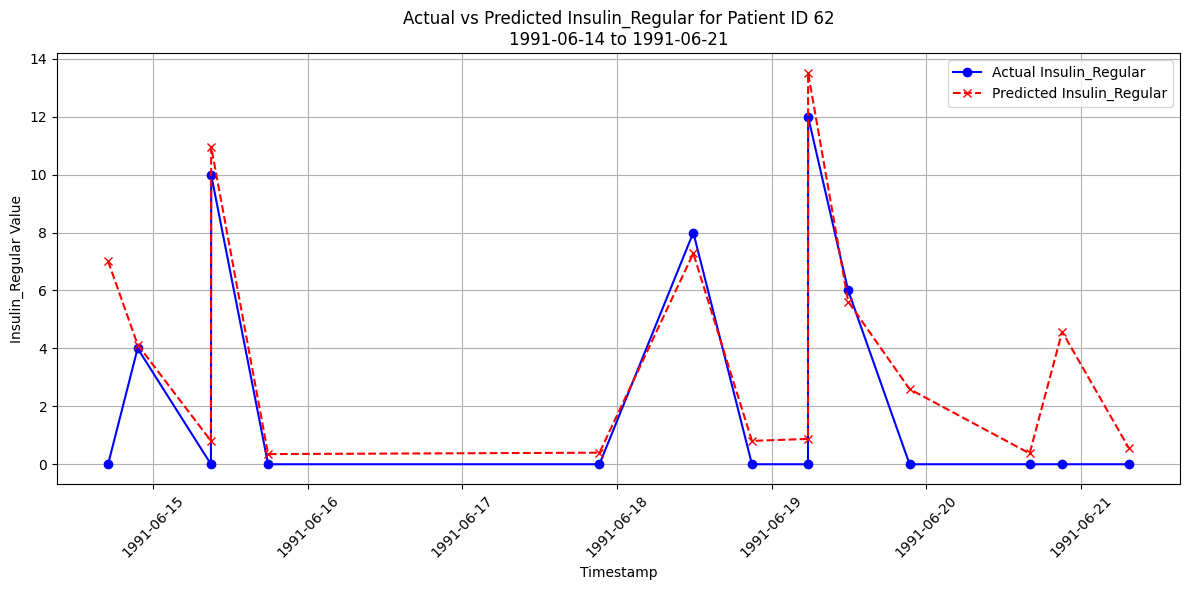

Plotted data for patient_id 62 from 1991-06-14 17:01:00 to 1991-06-21 17:01:00


In [ ]:
plot_actual_vs_predicted_one_week(
    patient_id_to_plot=62,
    patient_ids_test=patient_ids_test,
    timestamps_test=timestamps_test,
    y_test=y_test_unscaled,
    y_pred=y_pred_unscaled
)

In [ ]:
# Save the model in .h5 format
model_save_path = os.path.join(model_dir, 'insulin_lstm_gru_transformer_model.h5')
model.save(model_save_path, save_format='h5')

# Save weights separately
model.save_weights(os.path.join(model_dir, 'insulin_lstm_gru_transformer_model.weights.h5'))

# 14 april

In [ ]:
#mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Dropout, MultiHeadAttention, LayerNormalization, Bidirectional, Add
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import os
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, Callback

In [ ]:
# === Data Preprocessing ===
data = pd.read_csv('/content/drive/MyDrive/MINI01/processed-diabetes-data/combined_data.csv')
data['Value'] = pd.to_numeric(data['Value'], errors='coerce')
data['datetime'] = pd.to_datetime(data['datetime'])

# Pivot table
glucose_codes = [48, 57, 58, 59, 60, 61, 62, 63, 64]
long_acting_codes = [34, 35]

<ipython-input-26-0f0379081daf>:4: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data['datetime'] = pd.to_datetime(data['datetime'])


In [ ]:
pivoted_data = data.pivot_table(index=['patient_id', 'datetime'],
                                columns='Code', values='Value',
                                aggfunc='first').reset_index()

# Aggregate features
pivoted_data['Glucose'] = pivoted_data[glucose_codes].max(axis=1)
pivoted_data['Insulin_LongActing'] = pivoted_data[long_acting_codes].max(axis=1)
pivoted_data['Insulin_Regular'] = pivoted_data.get(33, 0)
pivoted_data['Hypoglycemia'] = pivoted_data.get(65, 0).apply(lambda x: 1 if x > 0 else 0)

In [ ]:
# Drop unnecessary columns
pivoted_data = pivoted_data.drop(columns=[col for col in pivoted_data.columns if isinstance(col, (int, float))])
pivoted_data = pivoted_data.sort_values(['patient_id', 'datetime'])

# Feature engineering
pivoted_data['Hour'] = pivoted_data['datetime'].dt.hour
pivoted_data['Minute'] = pivoted_data['datetime'].dt.minute
pivoted_data['DayOfWeek'] = pivoted_data['datetime'].dt.dayofweek

In [ ]:
# Interpolate glucose
pivoted_data['Glucose'] = pivoted_data.groupby('patient_id')['Glucose'].transform(
    lambda x: x.replace(0, np.nan).interpolate(method='linear').ffill().bfill()
)
pivoted_data['Glucose'] = pivoted_data['Glucose'].fillna(pivoted_data['Glucose'].mean())

# Add glucose rate of change
pivoted_data['Glucose_RateOfChange'] = pivoted_data.groupby('patient_id')['Glucose'].diff().fillna(0)
# Clip outliers
pivoted_data['Glucose'] = pivoted_data['Glucose'].clip(upper=500)
pivoted_data['Insulin_Regular'] = pivoted_data['Insulin_Regular'].clip(upper=100)

In [ ]:
# Lag and rolling features
for lag in [1, 2, 3]:
    pivoted_data[f'Glucose_Lag{lag}'] = pivoted_data.groupby('patient_id')['Glucose'].shift(lag)
    pivoted_data[f'Insulin_Regular_Lag{lag}'] = pivoted_data.groupby('patient_id')['Insulin_Regular'].shift(lag)
pivoted_data['Glucose_RollingMean'] = pivoted_data.groupby('patient_id')['Glucose'].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean()
)
pivoted_data['Glucose_RollingStd'] = pivoted_data.groupby('patient_id')['Glucose'].transform(
    lambda x: x.rolling(window=3, min_periods=1).std()
)
pivoted_data['Glucose_Insulin_Interaction'] = pivoted_data['Glucose'] * pivoted_data['Insulin_Regular']

In [ ]:
# Fill missing values
pivoted_data = pivoted_data.fillna(method='ffill').fillna(method='bfill')

pivoted_data_with_time = pivoted_data.copy()
pivoted_data = pivoted_data.drop(columns=['datetime'])

<ipython-input-50-3134a43f45a4>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  pivoted_data = pivoted_data.fillna(method='ffill').fillna(method='bfill')


In [ ]:
# Feature list
features = ['Hour', 'Minute', 'DayOfWeek', 'Glucose', 'Insulin_LongActing', 'Hypoglycemia',
            'Glucose_Lag1', 'Glucose_Lag2', 'Glucose_Lag3',
            'Insulin_Regular_Lag1', 'Insulin_Regular_Lag2', 'Insulin_Regular_Lag3',
            'Glucose_RollingMean', 'Glucose_RollingStd', 'Glucose_Insulin_Interaction',
            'Glucose_RateOfChange']
target = 'Insulin_Regular'
window_size = 7

In [ ]:
# Prepare sequences
X, y, patient_ids, timestamps = [], [], [], []

for patient in pivoted_data['patient_id'].unique():
    patient_data = pivoted_data[pivoted_data['patient_id'] == patient].copy()
    patient_data_with_time = pivoted_data_with_time[pivoted_data_with_time['patient_id'] == patient].copy()

    if len(patient_data) < window_size + 1:
        continue

    for i in range(len(patient_data) - window_size):
        X.append(patient_data[features].iloc[i:i+window_size].values)
        y.append(patient_data[target].iloc[i+window_size])
        patient_ids.append(patient)
        timestamps.append(patient_data_with_time['datetime'].iloc[i+window_size])

In [ ]:
X = np.array(X)
y = np.array(y)
patient_ids = np.array(patient_ids)
timestamps = np.array(timestamps)

# Global scaling
scaler_features = StandardScaler()
X_scaled = scaler_features.fit_transform(X.reshape(-1, len(features))).reshape(X.shape)

scaler_target = StandardScaler()
y_scaled = scaler_target.fit_transform(y.reshape(-1, 1)).flatten()

In [ ]:
# Train-test split
X_temp, X_test, y_temp, y_test, patient_ids_temp, patient_ids_test, timestamps_temp, timestamps_test = train_test_split(
    X_scaled, y_scaled, patient_ids, timestamps, test_size=0.2, random_state=42, stratify=patient_ids)

X_train, X_val, y_train, y_val, patient_ids_train, patient_ids_val = train_test_split(
    X_temp, y_temp, patient_ids_temp, test_size=0.2, random_state=42, stratify=patient_ids_temp)

In [ ]:
class CosineAnnealingScheduler(tf.keras.callbacks.Callback):
    def __init__(self, max_lr=0.0003, min_lr=1e-6, T_max=50):
        super(CosineAnnealingScheduler, self).__init__()
        self.max_lr = max_lr
        self.min_lr = min_lr
        self.T_max = T_max
        self.current_epoch = 0

    def on_epoch_begin(self, epoch, logs=None):
        self.current_epoch = epoch
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (
            1 + np.cos(np.pi * (self.current_epoch % self.T_max) / self.T_max)
        )
        tf.keras.backend.set_value(self.model.optimizer.lr, lr)

In [ ]:
def build_optimized_lstm_gru_model(input_shape):
    inputs = Input(shape=input_shape)

    # First LSTM block with residual connection
    x = LSTM(64, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001))(inputs)
    x = LayerNormalization()(x)
    x = Dropout(0.3)(x)
    x_shortcut = x  # Save for residual
    x = LSTM(32, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = LayerNormalization()(x)
    x = Dropout(0.3)(x)
    # Apply a Dense layer to x_shortcut to match the shape of x
    x_shortcut = Dense(32)(x_shortcut)  # Now x_shortcut has shape (7, 32)
    x = Add()([x, x_shortcut])  # Residual connection

    # GRU block
    x = GRU(32, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = LayerNormalization()(x)
    x = Dropout(0.3)(x)
    x_shortcut = x
    x = GRU(16, return_sequences=False, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = LayerNormalization()(x)
    x = Dropout(0.3)(x)
    x = Add()([x, Dense(16)(x_shortcut[:, -1, :])])  # Residual connection for last timestep

    # Dense layers
    x = Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = Dropout(0.3)(x)
    x = Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1)(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
# === Model Training ===
model_dir = '/content/drive/MyDrive/MINI01/pp2_models/'
results_dir = '/content/drive/MyDrive/MINI01/pp2_results/'
os.makedirs(model_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

In [ ]:
model = build_optimized_lstm_gru_model(input_shape=(window_size, len(features)))

optimizer = Adam(learning_rate=0.0003, clipnorm=1.0)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
cosine_scheduler = CosineAnnealingScheduler(max_lr=0.0003, min_lr=1e-6, T_max=50)

model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=70,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/70
357/357 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.5523 - mae: 0.4212 - val_loss: 0.3883 - val_mae: 0.3896 - learning_rate: 3.0000e-04
Epoch 2/70
357/357 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.4315 - mae: 0.4145 - val_loss: 0.3861 - val_mae: 0.3908 - learning_rate: 3.0000e-04
Epoch 3/70
357/357 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.4883 - mae: 0.4156 - val_loss: 0.3784 - val_mae: 0.3898 - learning_rate: 3.0000e-04
Epoch 4/70
357/357 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.4106 - mae: 0.4045 - val_loss: 0.3819 - val_mae: 0.3855 - learning_rate: 3.0000e-04
Epoch 5/70
357/357 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.3831 - mae: 0.4015 - val_loss: 0.3655 - val_mae: 0.3728 - learning_rate: 3.0000e-04
Epoch 6/70
357/357 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.4436 - mae: 0.4078 - val_loss: 0.3636 - val_mae: 0.3777 - learning_rate: 3.0000e-04
Epoch 7/70
357/357 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.4343 - mae: 0.4059 - val_loss: 0.3540 - val_mae: 0.36

In [ ]:
y_pred_scaled = model.predict(X_test)
y_pred = scaler_target.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_target.inverse_transform(y_test.reshape(-1, 1))

r2 = r2_score(y_test_unscaled, y_pred)
mae = mean_absolute_error(y_test_unscaled, y_pred)
mse = mean_squared_error(y_test_unscaled, y_pred)
mase = np.mean(np.abs(y_pred - y_test_unscaled)) / np.mean(np.abs(y_test_unscaled[1:] - y_test_unscaled[:-1]))

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [ ]:
print(f"R²: {r2:.3f}")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"MASE: {mase:.2f}")

R²: 0.805
MAE: 1.29
MSE: 3.27
MASE: 0.29


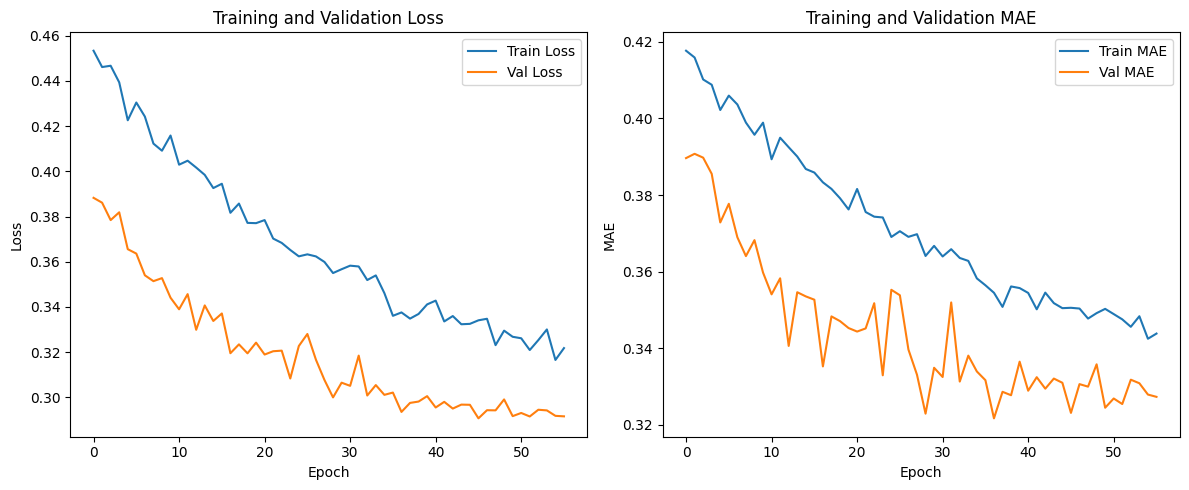

In [ ]:
import matplotlib.pyplot as plt

# Plot Training and Validation Loss
plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# MAE Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'train_val_loss_mae.png'))
plt.show()

In [ ]:
patient_index_map = {}
for pid in np.unique(patient_ids_test):
    patient_index_map[pid] = np.where(patient_ids_test == pid)[0]

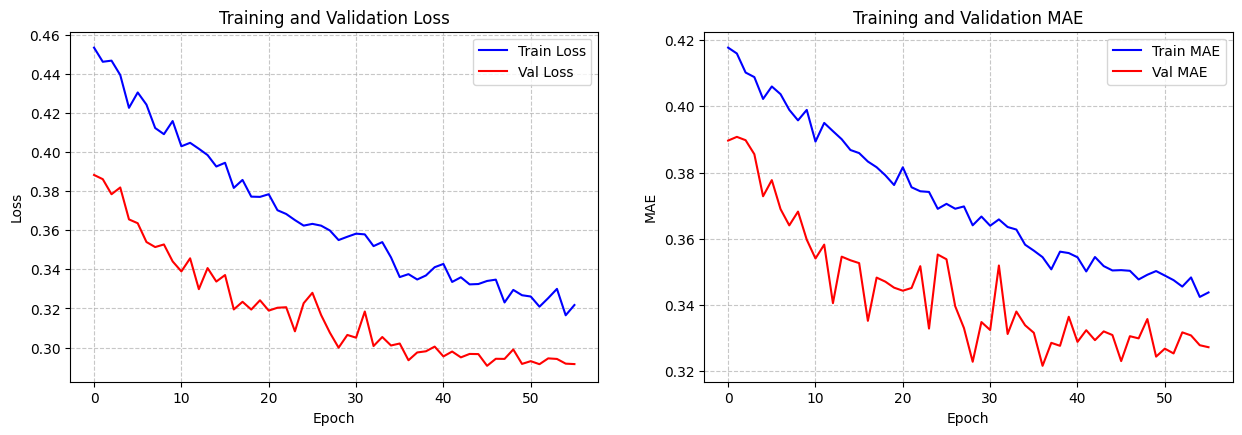

In [ ]:
plt.figure(figsize=(15, 10))

# Subplot 1: Training and Validation Loss
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Val Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Subplot 2: Training and Validation MAE
plt.subplot(2, 2, 2)
plt.plot(history.history['mae'], label='Train MAE', color='blue')
plt.plot(history.history['val_mae'], label='Val MAE', color='red')
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

In [ ]:
model.save(os.path.join(model_dir, 'optimized_lstm_gru_model.h5'))

In [ ]:
def plot_actual_vs_predicted_weekly(patient_id_to_plot, patient_ids_test, timestamps_test, y_test, y_pred, results_dir):
    # Filter data for the specific patient
    mask = patient_ids_test == patient_id_to_plot
    if not np.any(mask):
        print(f"No test data found for patient_id {patient_id_to_plot}")
        return

    patient_timestamps = timestamps_test[mask]
    patient_actual = y_test[mask].flatten()
    patient_predicted = y_pred[mask].flatten()

    # Create DataFrame for easier date handling
    df = pd.DataFrame({
        'time': patient_timestamps,
        'actual': patient_actual,
        'predicted': patient_predicted
    })
    df['time'] = pd.to_datetime(df['time'])

    # Sort by time
    df = df.sort_values('time')

    # Initialize date range
    start_date = df['time'].min().floor('D')
    end_date = df['time'].max().floor('D')

    # Plot each week
    current_start = start_date
    plot_count = 0
    while current_start < end_date:
        current_end = current_start + timedelta(days=7)
        week_mask = (df['time'] >= current_start) & (df['time'] < current_end)
        week_df = df[week_mask]

        if len(week_df) == 0:
            print(f"No data for patient_id {patient_id_to_plot} from {current_start.date()} to {current_end.date()}")
            current_start += timedelta(days=7)
            continue

        # Create plot
        plt.figure(figsize=(12, 6))
        plt.plot(week_df['time'], week_df['actual'], label='Actual Insulin_Regular', color='blue', linestyle='-', marker='o', markersize=5)
        plt.plot(week_df['time'], week_df['predicted'], label='Predicted Insulin_Regular', color='red', linestyle='--', marker='x', markersize=5)
        plt.xlabel('Timestamp')
        plt.ylabel('Insulin Dose (Units)')
        plt.title(f'Actual vs Predicted Insulin for Patient ID {patient_id_to_plot}\n{current_start.date()} to {current_end.date()}')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.xticks(rotation=45)
        plt.tight_layout()

        # Save plot
        plot_save_path = os.path.join(results_dir, f'actual_vs_predicted_patient_{patient_id_to_plot}_week_{plot_count}.png')
        plt.savefig(plot_save_path)
        plt.show()

        print(f"Plotted data for patient_id {patient_id_to_plot} from {current_start.date()} to {current_end.date()}")
        current_start += timedelta(days=7)
        plot_count += 1

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import timedelta
import os

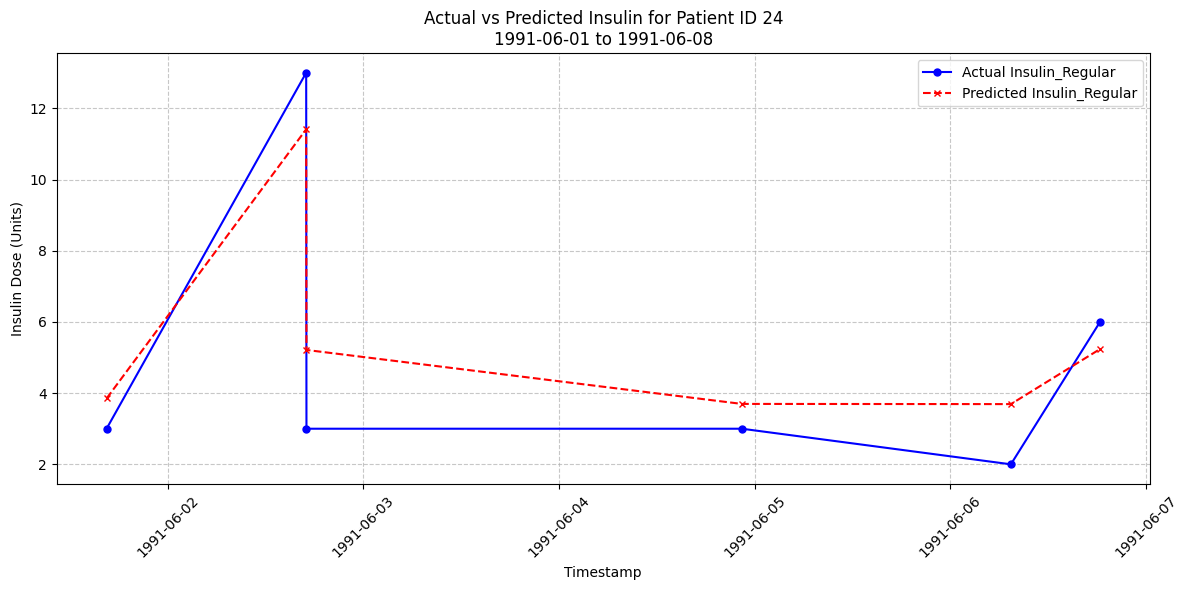

Plotted data for patient_id 24 from 1991-06-01 to 1991-06-08


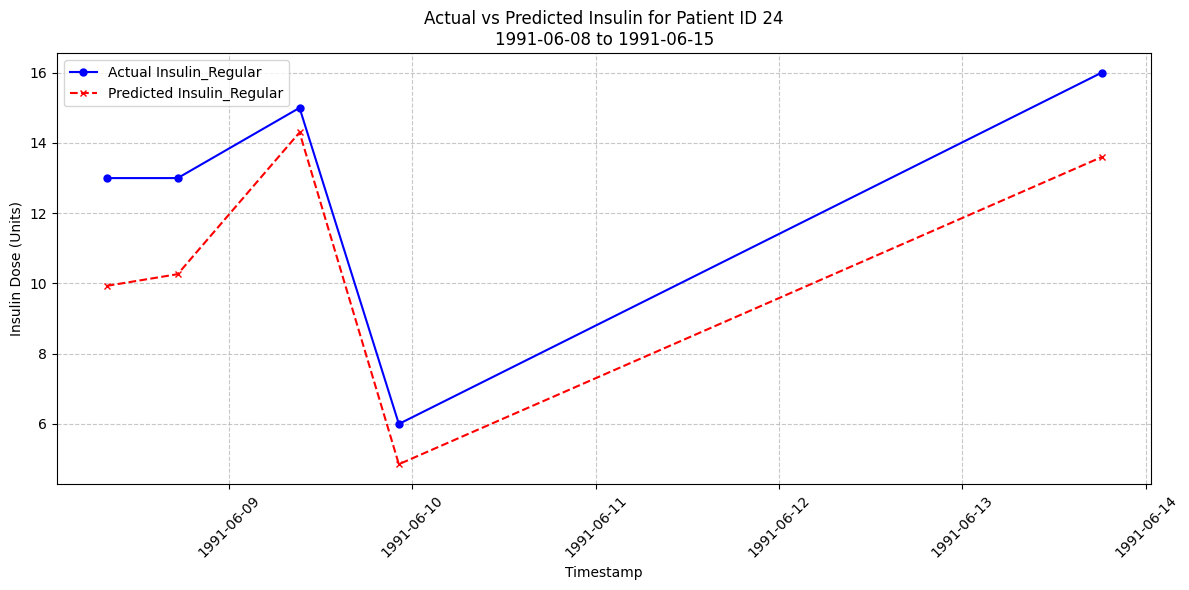

Plotted data for patient_id 24 from 1991-06-08 to 1991-06-15


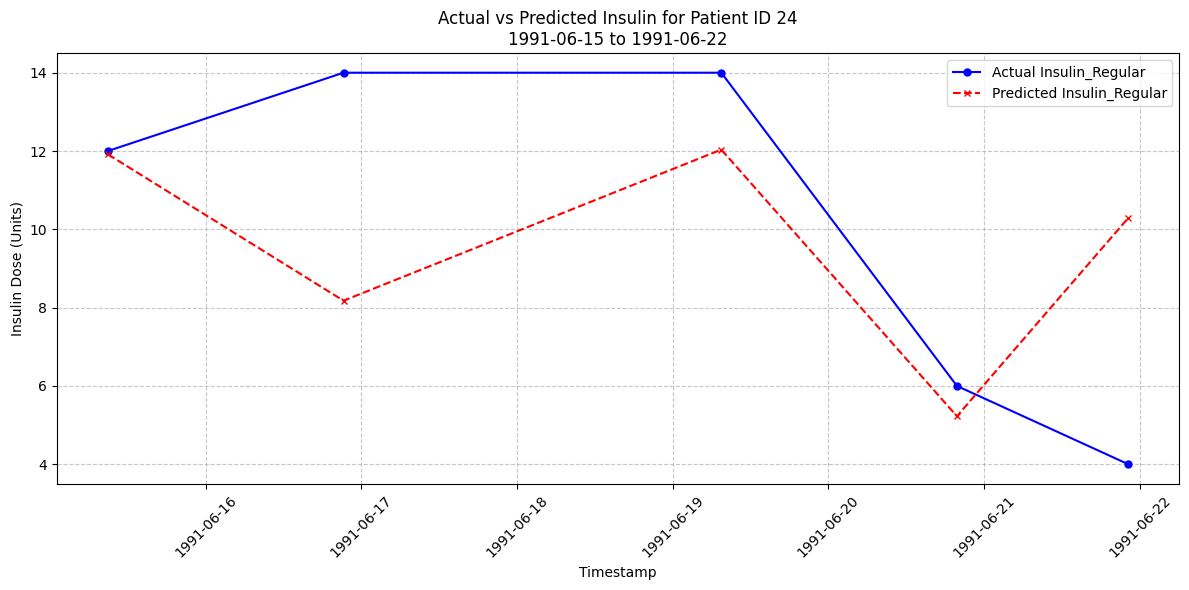

Plotted data for patient_id 24 from 1991-06-15 to 1991-06-22


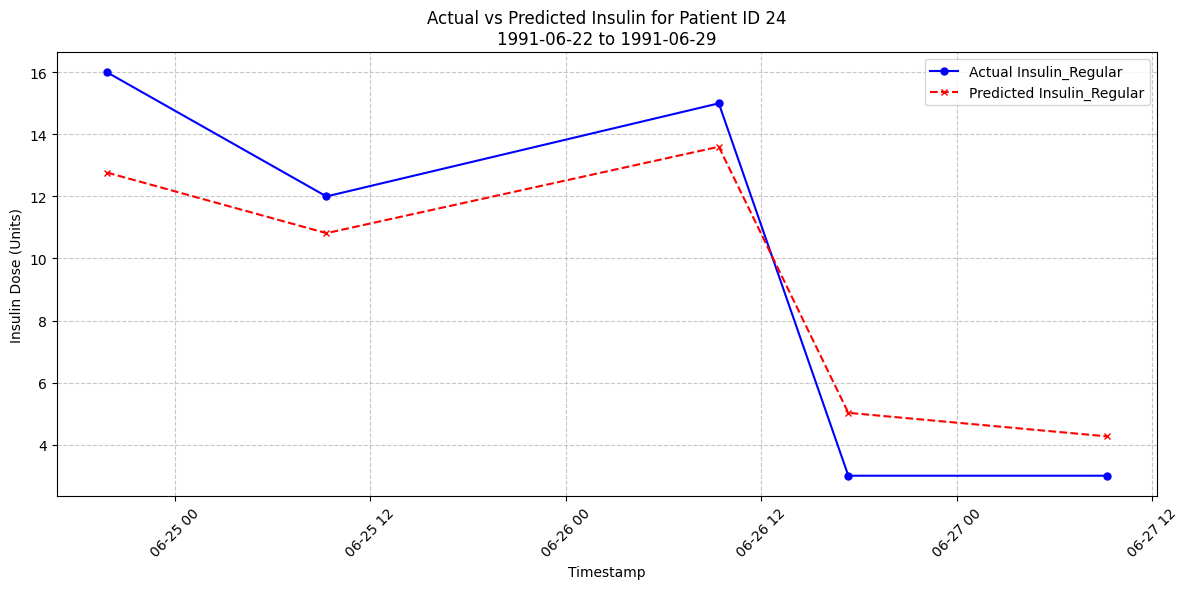

Plotted data for patient_id 24 from 1991-06-22 to 1991-06-29


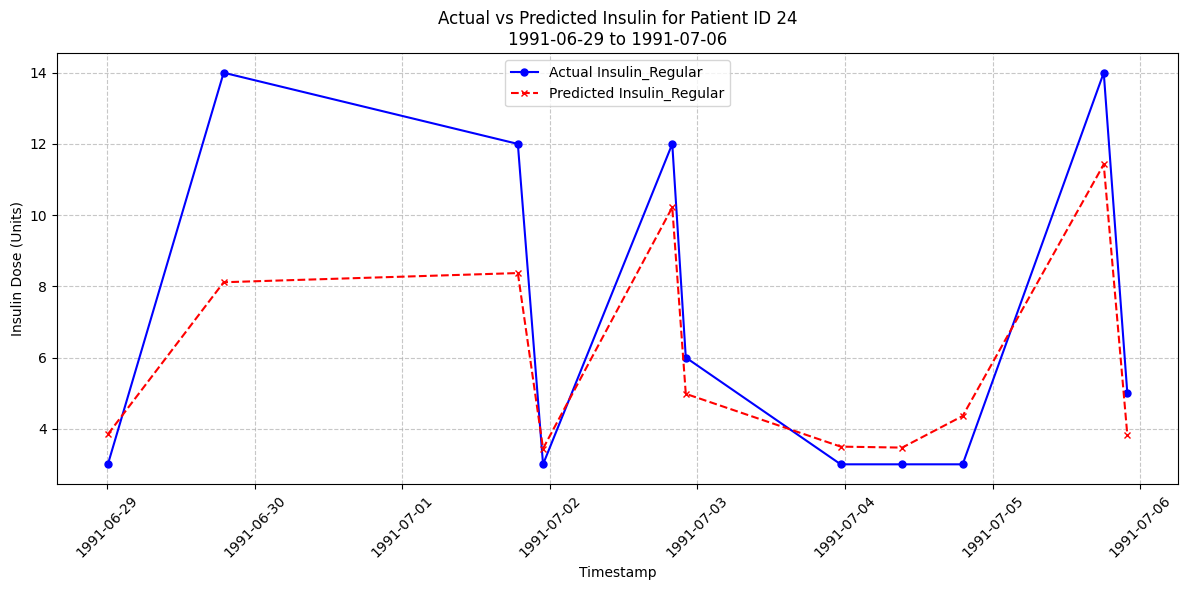

Plotted data for patient_id 24 from 1991-06-29 to 1991-07-06


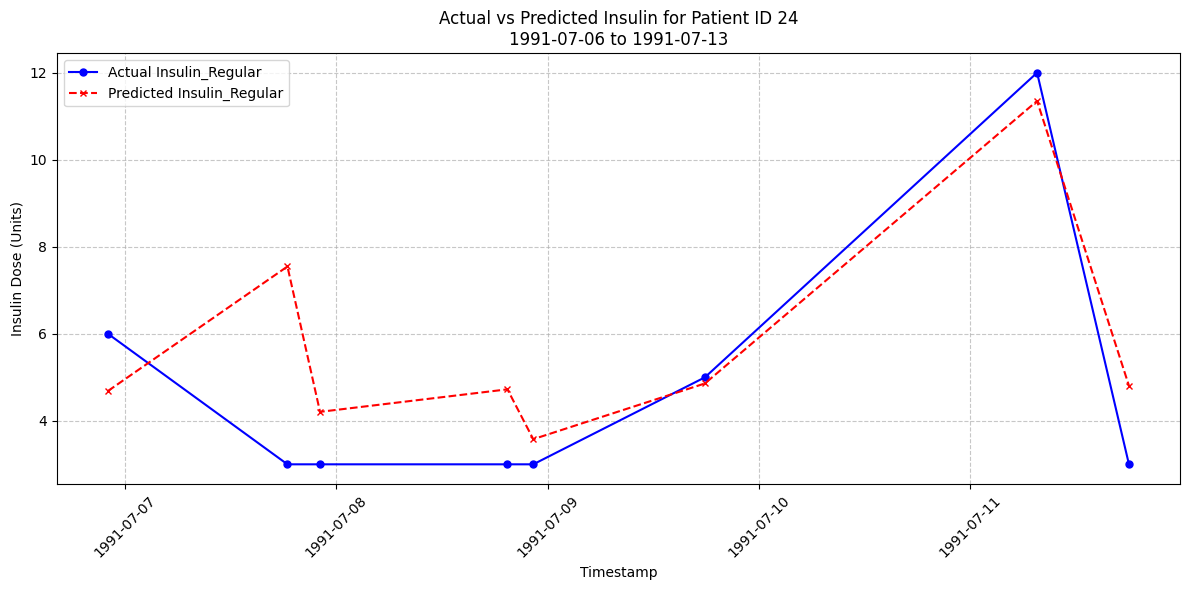

Plotted data for patient_id 24 from 1991-07-06 to 1991-07-13


In [ ]:
patient_id_to_plot = 24 # Replace with desired patient ID
plot_actual_vs_predicted_weekly(
    patient_id_to_plot=patient_id_to_plot,
    patient_ids_test=patient_ids_test,
    timestamps_test=timestamps_test,
    y_test=y_test_unscaled,
    y_pred=y_pred,
    results_dir=results_dir
)

# 20

In [ ]:
#mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Dropout, MultiHeadAttention, LayerNormalization, Bidirectional, Add
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import os
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, Callback

In [ ]:
# === Data Preprocessing ===
data = pd.read_csv('/content/drive/MyDrive/MINI01/processed-diabetes-data/combined_data.csv')
data['Value'] = pd.to_numeric(data['Value'], errors='coerce')
data['datetime'] = pd.to_datetime(data['datetime'])

# Pivot table
glucose_codes = [48, 57, 58, 59, 60, 61, 62, 63, 64]
long_acting_codes = [34, 35]

<ipython-input-3-0f0379081daf>:4: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data['datetime'] = pd.to_datetime(data['datetime'])


In [ ]:
pivoted_data = data.pivot_table(index=['patient_id', 'datetime'],
                                columns='Code', values='Value',
                                aggfunc='first').reset_index()

# Aggregate features
pivoted_data['Glucose'] = pivoted_data[glucose_codes].max(axis=1)
pivoted_data['Insulin_LongActing'] = pivoted_data[long_acting_codes].max(axis=1)
pivoted_data['Insulin_Regular'] = pivoted_data.get(33, 0)
pivoted_data['Hypoglycemia'] = pivoted_data.get(65, 0).apply(lambda x: 1 if x > 0 else 0)

In [ ]:
# Drop unnecessary columns
pivoted_data = pivoted_data.drop(columns=[col for col in pivoted_data.columns if isinstance(col, (int, float))])
pivoted_data = pivoted_data.sort_values(['patient_id', 'datetime'])

# Feature engineering
pivoted_data['Hour'] = pivoted_data['datetime'].dt.hour
pivoted_data['Minute'] = pivoted_data['datetime'].dt.minute
pivoted_data['DayOfWeek'] = pivoted_data['datetime'].dt.dayofweek

In [ ]:
# Interpolate glucose
pivoted_data['Glucose'] = pivoted_data.groupby('patient_id')['Glucose'].transform(
    lambda x: x.replace(0, np.nan).interpolate(method='linear').ffill().bfill()
)
pivoted_data['Glucose'] = pivoted_data['Glucose'].fillna(pivoted_data['Glucose'].mean())

# Add glucose rate of change
pivoted_data['Glucose_RateOfChange'] = pivoted_data.groupby('patient_id')['Glucose'].diff().fillna(0)
# Clip outliers
pivoted_data['Glucose'] = pivoted_data['Glucose'].clip(upper=500)
pivoted_data['Insulin_Regular'] = pivoted_data['Insulin_Regular'].clip(upper=100)

In [ ]:
# Lag and rolling features
for lag in [1, 2, 3]:
    pivoted_data[f'Glucose_Lag{lag}'] = pivoted_data.groupby('patient_id')['Glucose'].shift(lag)
    pivoted_data[f'Insulin_Regular_Lag{lag}'] = pivoted_data.groupby('patient_id')['Insulin_Regular'].shift(lag)
pivoted_data['Glucose_RollingMean'] = pivoted_data.groupby('patient_id')['Glucose'].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean()
)
pivoted_data['Glucose_RollingStd'] = pivoted_data.groupby('patient_id')['Glucose'].transform(
    lambda x: x.rolling(window=3, min_periods=1).std()
)
pivoted_data['Glucose_Insulin_Interaction'] = pivoted_data['Glucose'] * pivoted_data['Insulin_Regular']

In [ ]:
# Fill missing values
pivoted_data = pivoted_data.fillna(method='ffill').fillna(method='bfill')

pivoted_data_with_time = pivoted_data.copy()
pivoted_data = pivoted_data.drop(columns=['datetime'])

<ipython-input-8-3134a43f45a4>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  pivoted_data = pivoted_data.fillna(method='ffill').fillna(method='bfill')


In [ ]:
# Feature list
features = ['Hour', 'Minute', 'DayOfWeek', 'Glucose', 'Insulin_LongActing', 'Hypoglycemia',
            'Glucose_Lag1', 'Glucose_Lag2', 'Glucose_Lag3',
            'Insulin_Regular_Lag1', 'Insulin_Regular_Lag2', 'Insulin_Regular_Lag3',
            'Glucose_RollingMean', 'Glucose_RollingStd', 'Glucose_Insulin_Interaction',
            'Glucose_RateOfChange']
target = 'Insulin_Regular'
window_size = 7

In [ ]:
# Prepare sequences
X, y, patient_ids, timestamps = [], [], [], []

for patient in pivoted_data['patient_id'].unique():
    patient_data = pivoted_data[pivoted_data['patient_id'] == patient].copy()
    patient_data_with_time = pivoted_data_with_time[pivoted_data_with_time['patient_id'] == patient].copy()

    if len(patient_data) < window_size + 1:
        continue

    for i in range(len(patient_data) - window_size):
        X.append(patient_data[features].iloc[i:i+window_size].values)
        y.append(patient_data[target].iloc[i+window_size])
        patient_ids.append(patient)
        timestamps.append(patient_data_with_time['datetime'].iloc[i+window_size])

In [ ]:
X = np.array(X)
y = np.array(y)
patient_ids = np.array(patient_ids)
timestamps = np.array(timestamps)

# Global scaling
scaler_features = StandardScaler()
X_scaled = scaler_features.fit_transform(X.reshape(-1, len(features))).reshape(X.shape)

scaler_target = StandardScaler()
y_scaled = scaler_target.fit_transform(y.reshape(-1, 1)).flatten()

In [ ]:
# Train-test split
X_temp, X_test, y_temp, y_test, patient_ids_temp, patient_ids_test, timestamps_temp, timestamps_test = train_test_split(
    X_scaled, y_scaled, patient_ids, timestamps, test_size=0.2, random_state=42, stratify=patient_ids)

X_train, X_val, y_train, y_val, patient_ids_train, patient_ids_val = train_test_split(
    X_temp, y_temp, patient_ids_temp, test_size=0.2, random_state=42, stratify=patient_ids_temp)

In [ ]:
import tensorflow as tf
import numpy as np

class CosineAnnealingScheduler(tf.keras.callbacks.Callback):
    def __init__(self, max_lr=0.0003, min_lr=1e-6, T_max=50):
        super(CosineAnnealingScheduler, self).__init__()
        self.max_lr = max_lr
        self.min_lr = min_lr
        self.T_max = T_max
        self.current_epoch = 0

    def on_epoch_begin(self, epoch, logs=None):
        self.current_epoch = epoch
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (
            1 + np.cos(np.pi * (self.current_epoch % self.T_max) / self.T_max)
        )
        # Safely update the learning rate
        if isinstance(self.model.optimizer.learning_rate, tf.Variable):
            tf.keras.backend.set_value(self.model.optimizer.learning_rate, lr)
        else:
            self.model.optimizer.learning_rate.assign(lr)

In [ ]:
def build_optimized_lstm_gru_model(input_shape):
    inputs = Input(shape=input_shape)

    # First LSTM block with residual connection
    x = LSTM(64, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001))(inputs)
    x = LayerNormalization()(x)
    x = Dropout(0.3)(x)
    x_shortcut = x  # Save for residual
    x = LSTM(32, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = LayerNormalization()(x)
    x = Dropout(0.3)(x)
    # Apply a Dense layer to x_shortcut to match the shape of x
    x_shortcut = Dense(32)(x_shortcut)  # Now x_shortcut has shape (7, 32)
    x = Add()([x, x_shortcut])  # Residual connection

    # GRU block
    x = GRU(32, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = LayerNormalization()(x)
    x = Dropout(0.3)(x)
    x_shortcut = x
    x = GRU(16, return_sequences=False, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = LayerNormalization()(x)
    x = Dropout(0.3)(x)
    x = Add()([x, Dense(16)(x_shortcut[:, -1, :])])  # Residual connection for last timestep

    # Dense layers
    x = Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = Dropout(0.3)(x)
    x = Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1)(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
# === Model Training ===
model_dir = '/content/drive/MyDrive/MINI01/pp2_models/'
results_dir = '/content/drive/MyDrive/MINI01/pp2_results/'
os.makedirs(model_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

In [ ]:
model = build_optimized_lstm_gru_model(input_shape=(window_size, len(features)))

optimizer = Adam(learning_rate=0.0003, clipnorm=1.0)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
cosine_scheduler = CosineAnnealingScheduler(max_lr=0.0003, min_lr=1e-6, T_max=50)

model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, cosine_scheduler],
    verbose=1
)

Epoch 1/100
357/357 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - loss: 1.6259 - mae: 0.8928 - val_loss: 0.7963 - val_mae: 0.5704
Epoch 2/100
357/357 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.8112 - mae: 0.5752 - val_loss: 0.6805 - val_mae: 0.5105
Epoch 3/100
357/357 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 0.7545 - mae: 0.5366 - val_loss: 0.6312 - val_mae: 0.4775
Epoch 4/100
357/357 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.7570 - mae: 0.5141 - val_loss: 0.6261 - val_mae: 0.4869
Epoch 5/100
357/357 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.6756 - mae: 0.5014 - val_loss: 0.5969 - val_mae: 0.4706
Epoch 6/100
357/357 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.6182 - mae: 0.4892 - val_loss: 0.5840 - val_mae: 0.4687
Epoch 7/100
357/357 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.5984 - mae: 0.4781 - val_loss: 0.5384 - val_mae: 0.4424
Epoch 8/100
357/357 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.7065 - mae: 0.4743 - val_loss: 0.5341 - val_mae: 0.4457
Epoch 9/100
357/357 ━━━━━━━━━━━━━━━━

In [ ]:
y_pred_scaled = model.predict(X_test)
y_pred = scaler_target.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_target.inverse_transform(y_test.reshape(-1, 1))

r2 = r2_score(y_test_unscaled, y_pred)
mae = mean_absolute_error(y_test_unscaled, y_pred)
mse = mean_squared_error(y_test_unscaled, y_pred)
mase = np.mean(np.abs(y_pred - y_test_unscaled)) / np.mean(np.abs(y_test_unscaled[1:] - y_test_unscaled[:-1]))

112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [ ]:
print(f"R²: {r2:.3f}")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"MASE: {mase:.2f}")

R²: 0.806
MAE: 1.25
MSE: 3.26
MASE: 0.28


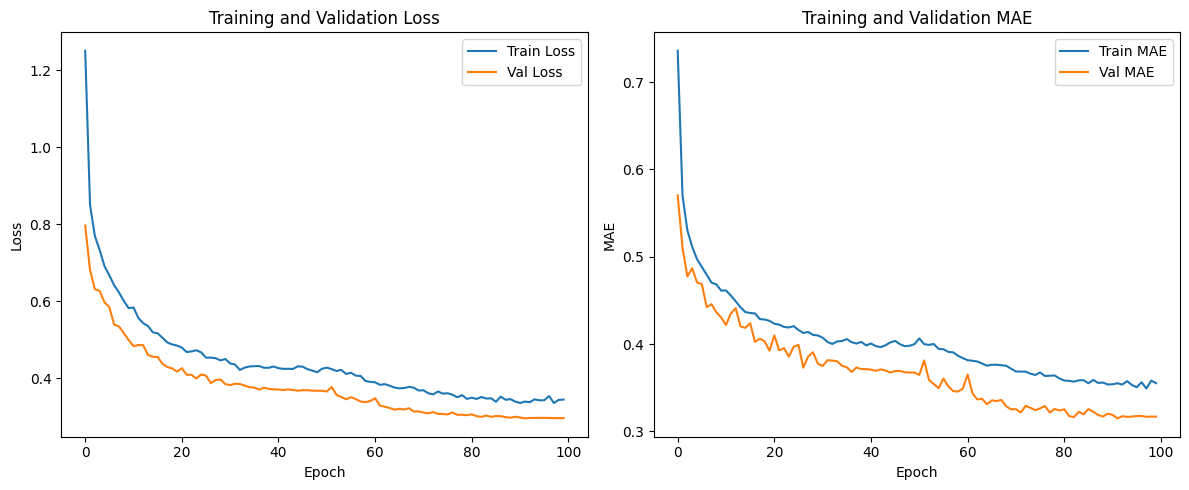

In [ ]:
import matplotlib.pyplot as plt

# Plot Training and Validation Loss
plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# MAE Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'train_val_loss_mae.png'))
plt.show()

In [ ]:
patient_index_map = {}
for pid in np.unique(patient_ids_test):
    patient_index_map[pid] = np.where(patient_ids_test == pid)[0]

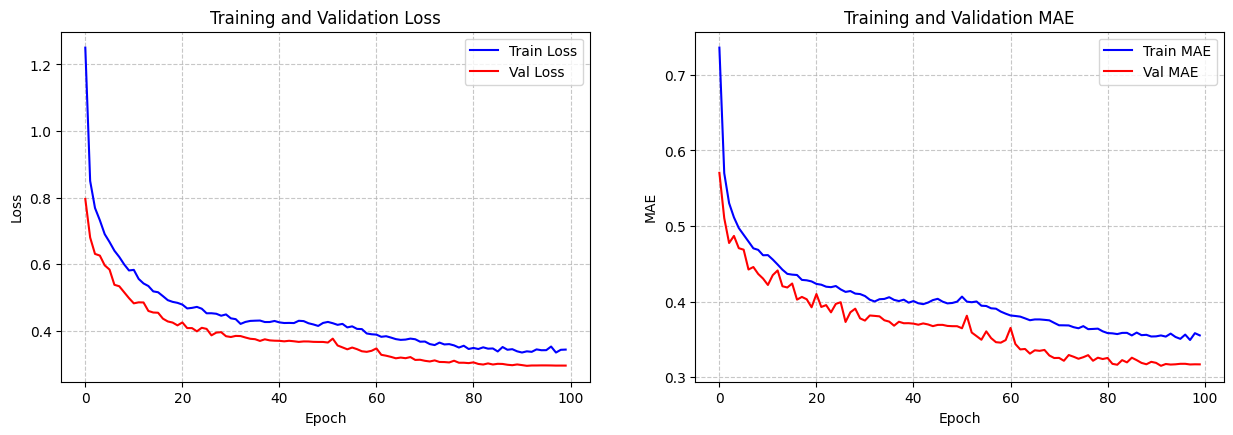

In [ ]:
plt.figure(figsize=(15, 10))

# Subplot 1: Training and Validation Loss
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Val Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Subplot 2: Training and Validation MAE
plt.subplot(2, 2, 2)
plt.plot(history.history['mae'], label='Train MAE', color='blue')
plt.plot(history.history['val_mae'], label='Val MAE', color='red')
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

In [ ]:
model.save(os.path.join(model_dir, 'optimized_lstm_gru_model_80.6.h5'))

In [ ]:
def plot_actual_vs_predicted_weekly(patient_id_to_plot, patient_ids_test, timestamps_test, y_test, y_pred, results_dir):
    # Filter data for the specific patient
    mask = patient_ids_test == patient_id_to_plot
    if not np.any(mask):
        print(f"No test data found for patient_id {patient_id_to_plot}")
        return

    patient_timestamps = timestamps_test[mask]
    patient_actual = y_test[mask].flatten()
    patient_predicted = y_pred[mask].flatten()

    # Create DataFrame for easier date handling
    df = pd.DataFrame({
        'time': patient_timestamps,
        'actual': patient_actual,
        'predicted': patient_predicted
    })
    df['time'] = pd.to_datetime(df['time'])

    # Sort by time
    df = df.sort_values('time')

    # Initialize date range
    start_date = df['time'].min().floor('D')
    end_date = df['time'].max().floor('D')

    # Plot each week
    current_start = start_date
    plot_count = 0
    while current_start < end_date:
        current_end = current_start + timedelta(days=7)
        week_mask = (df['time'] >= current_start) & (df['time'] < current_end)
        week_df = df[week_mask]

        if len(week_df) == 0:
            print(f"No data for patient_id {patient_id_to_plot} from {current_start.date()} to {current_end.date()}")
            current_start += timedelta(days=7)
            continue

        # Create plot
        plt.figure(figsize=(12, 6))
        plt.plot(week_df['time'], week_df['actual'], label='Actual Insulin_Regular', color='blue', linestyle='-', marker='o', markersize=5)
        plt.plot(week_df['time'], week_df['predicted'], label='Predicted Insulin_Regular', color='red', linestyle='--', marker='x', markersize=5)
        plt.xlabel('Timestamp')
        plt.ylabel('Insulin Dose (Units)')
        plt.title(f'Actual vs Predicted Insulin for Patient ID {patient_id_to_plot}\n{current_start.date()} to {current_end.date()}')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.xticks(rotation=45)
        plt.tight_layout()

        # Save plot
        plot_save_path = os.path.join(results_dir, f'actual_vs_predicted_patient_{patient_id_to_plot}_week_{plot_count}.png')
        plt.savefig(plot_save_path)
        plt.show()

        print(f"Plotted data for patient_id {patient_id_to_plot} from {current_start.date()} to {current_end.date()}")
        current_start += timedelta(days=7)
        plot_count += 1

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import timedelta
import os

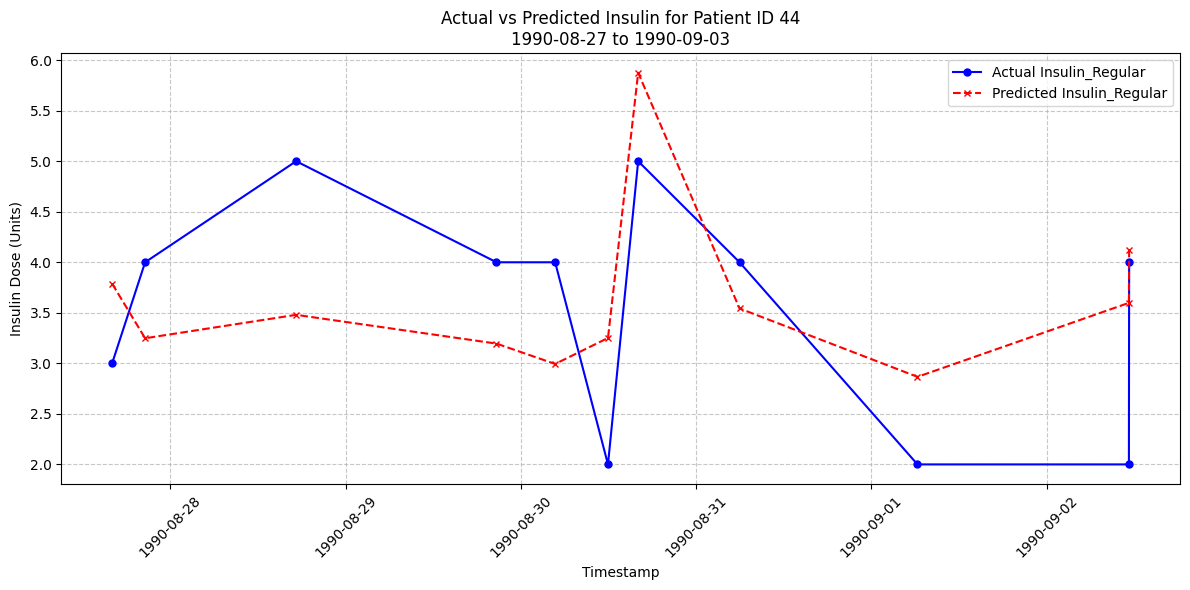

Plotted data for patient_id 44 from 1990-08-27 to 1990-09-03


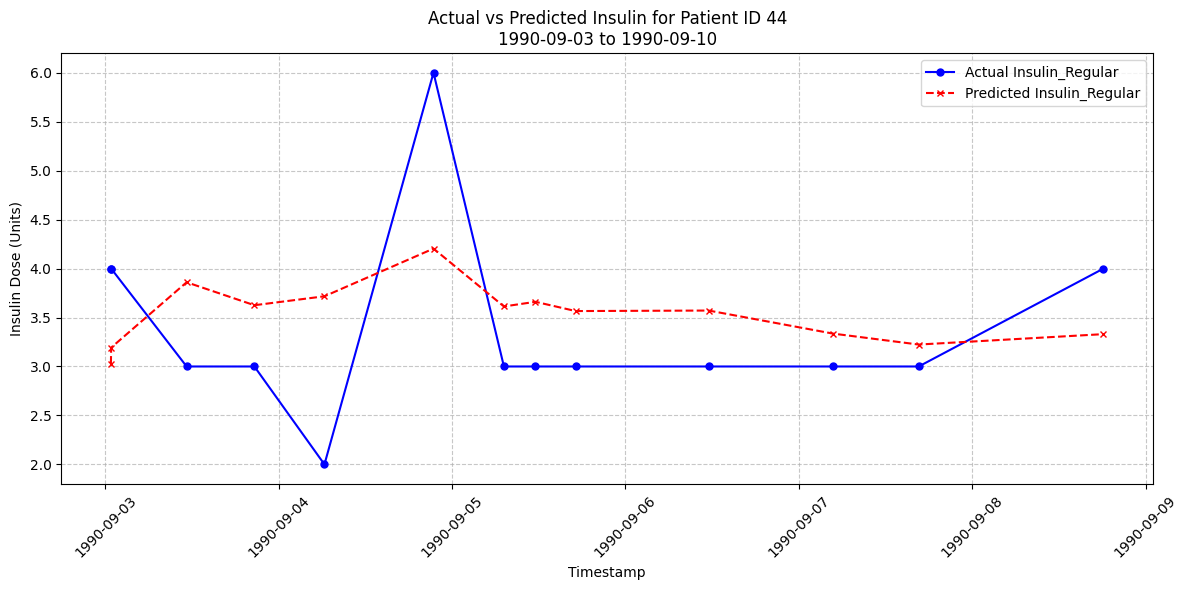

Plotted data for patient_id 44 from 1990-09-03 to 1990-09-10


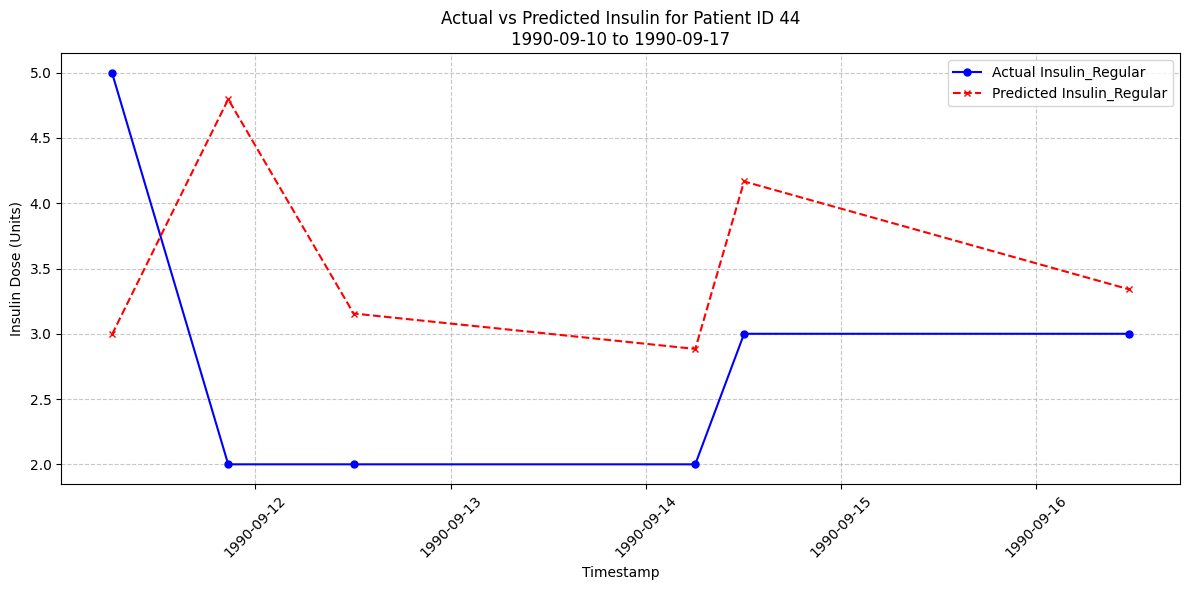

Plotted data for patient_id 44 from 1990-09-10 to 1990-09-17


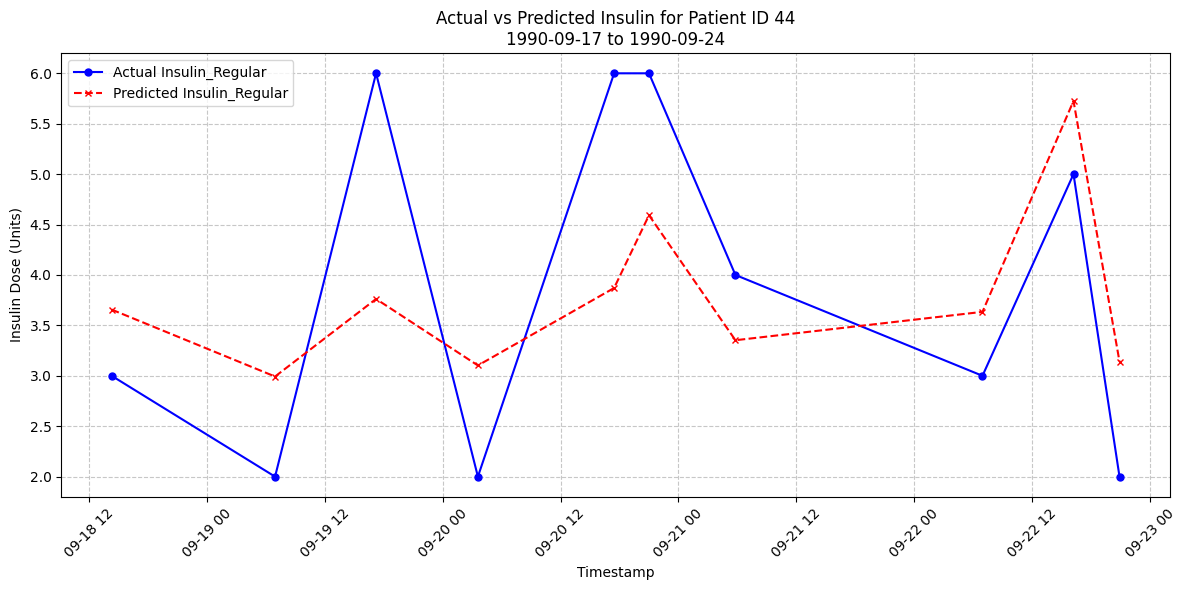

Plotted data for patient_id 44 from 1990-09-17 to 1990-09-24


In [ ]:
patient_id_to_plot = 44 # Replace with desired patient ID
plot_actual_vs_predicted_weekly(
    patient_id_to_plot=patient_id_to_plot,
    patient_ids_test=patient_ids_test,
    timestamps_test=timestamps_test,
    y_test=y_test_unscaled,
    y_pred=y_pred,
    results_dir=results_dir
)

# patinet wise splitting

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, LayerNormalization, Dropout, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/MINI01/processed-diabetes-data/combined_data.csv')
data['Value'] = pd.to_numeric(data['Value'], errors='coerce')
data['datetime'] = pd.to_datetime(data['datetime'])

# Pivot table
glucose_codes = [48, 57, 58, 59, 60, 61, 62, 63, 64]
long_acting_codes = [34, 35]
pivoted_data = data.pivot_table(index=['patient_id', 'datetime'], columns='Code', values='Value', aggfunc='first').reset_index()


<ipython-input-50-16d97fae83a7>:3: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data['datetime'] = pd.to_datetime(data['datetime'])


In [ ]:
# Aggregate features
pivoted_data['Glucose'] = pivoted_data[glucose_codes].max(axis=1)
pivoted_data['Insulin_LongActing'] = pivoted_data[long_acting_codes].max(axis=1)
pivoted_data['Insulin_Regular'] = pivoted_data.get(33, 0)
pivoted_data['Hypoglycemia'] = pivoted_data.get(65, 0).apply(lambda x: 1 if x > 0 else 0)

# Drop unnecessary columns
pivoted_data = pivoted_data.drop(columns=[col for col in pivoted_data.columns if isinstance(col, (int, float))])
pivoted_data = pivoted_data.sort_values(['patient_id', 'datetime'])


In [ ]:
# Feature engineering
pivoted_data['Hour'] = pivoted_data['datetime'].dt.hour
pivoted_data['Minute'] = pivoted_data['datetime'].dt.minute
pivoted_data['DayOfWeek'] = pivoted_data['datetime'].dt.dayofweek
pivoted_data['Glucose'] = pivoted_data.groupby('patient_id')['Glucose'].transform(
    lambda x: x.replace(0, np.nan).interpolate(method='linear').ffill().bfill()
).fillna(pivoted_data['Glucose'].mean())
pivoted_data['Glucose_RateOfChange'] = pivoted_data.groupby('patient_id')['Glucose'].diff().fillna(0)
pivoted_data['Glucose'] = pivoted_data['Glucose'].clip(upper=500)
pivoted_data['Insulin_Regular'] = pivoted_data['Insulin_Regular'].clip(upper=100)


In [ ]:
# Lag and rolling features
for lag in [1, 2, 3]:
    pivoted_data[f'Glucose_Lag{lag}'] = pivoted_data.groupby('patient_id')['Glucose'].shift(lag)
    pivoted_data[f'Insulin_Regular_Lag{lag}'] = pivoted_data.groupby('patient_id')['Insulin_Regular'].shift(lag)
pivoted_data['Glucose_RollingMean'] = pivoted_data.groupby('patient_id')['Glucose'].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean()
)
pivoted_data['Glucose_RollingStd'] = pivoted_data.groupby('patient_id')['Glucose'].transform(
    lambda x: x.rolling(window=3, min_periods=1).std()
)
pivoted_data['Glucose_Insulin_Interaction'] = pivoted_data['Glucose'] * pivoted_data['Insulin_Regular']
pivoted_data = pivoted_data.fillna(method='ffill').fillna(method='bfill')


<ipython-input-53-61c89c9cf740>:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  pivoted_data = pivoted_data.fillna(method='ffill').fillna(method='bfill')


In [ ]:

# Features and target
features = ['Hour', 'Minute', 'DayOfWeek', 'Glucose', 'Insulin_LongActing', 'Hypoglycemia',
            'Glucose_Lag1', 'Glucose_Lag2', 'Glucose_Lag3', 'Insulin_Regular_Lag1',
            'Insulin_Regular_Lag2', 'Insulin_Regular_Lag3', 'Glucose_RollingMean',
            'Glucose_RollingStd', 'Glucose_Insulin_Interaction', 'Glucose_RateOfChange']
target = 'Insulin_Regular'
window_size = 7

# === Patient-Exclusive Split ===
unique_patients = pivoted_data['patient_id'].unique()
train_val_patients, test_patients = train_test_split(unique_patients, test_size=0.2, random_state=42)
train_patients, val_patients = train_test_split(train_val_patients, test_size=0.2, random_state=42)


In [ ]:
train_val_patients

array([63, 31, 59, 36, 58, 48, 17, 35, 43, 29,  8, 54, 41, 45, 47, 20, 57,
       40, 26, 39, 14, 51,  4, 18,  9, 56,  7, 37, 65, 70, 69, 16, 28, 42,
       27, 49, 25, 60, 64, 12, 33, 67, 62, 38, 30, 44, 66,  2, 53, 22,  3,
       24, 21, 61, 15, 52])

In [ ]:
test_patients

array([23,  1, 50,  5, 55, 19, 11, 34, 46, 13, 32, 10, 68,  6])

In [ ]:
# Create sequences
def create_sequences(data, patient_ids, features, target, window_size):
    X, y = [], []
    for pid in patient_ids:
        patient_data = data[data['patient_id'] == pid][features + [target]]
        if len(patient_data) < window_size + 1:
            continue
        for i in range(len(patient_data) - window_size):
            X.append(patient_data[features].iloc[i:i+window_size].values)
            y.append(patient_data[target].iloc[i+window_size])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(pivoted_data, train_patients, features, target, window_size)
X_val, y_val = create_sequences(pivoted_data, val_patients, features, target, window_size)
X_test, y_test = create_sequences(pivoted_data, test_patients, features, target, window_size)


In [ ]:
# Scale data
scaler_features = StandardScaler()
X_train_scaled = scaler_features.fit_transform(X_train.reshape(-1, len(features))).reshape(X_train.shape)
X_val_scaled = scaler_features.transform(X_val.reshape(-1, len(features))).reshape(X_val.shape)
X_test_scaled = scaler_features.transform(X_test.reshape(-1, len(features))).reshape(X_test.shape)

scaler_target = StandardScaler()
y_train_scaled = scaler_target.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val_scaled = scaler_target.transform(y_val.reshape(-1, 1)).flatten()
y_test_scaled = scaler_target.transform(y_test.reshape(-1, 1)).flatten()


In [ ]:
class CosineAnnealingScheduler(tf.keras.callbacks.Callback):
    def __init__(self, max_lr=0.0003, min_lr=1e-6, T_max=50):
        super(CosineAnnealingScheduler, self).__init__()
        self.max_lr = max_lr
        self.min_lr = min_lr
        self.T_max = T_max
        self.current_epoch = 0
    def on_epoch_begin(self, epoch, logs=None):
        self.current_epoch = epoch
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (
            1 + np.cos(np.pi * (self.current_epoch % self.T_max) / self.T_max)
        )
        if isinstance(self.model.optimizer.learning_rate, tf.Variable):
            tf.keras.backend.set_value(self.model.optimizer.learning_rate, lr)
        else:
            self.model.optimizer.learning_rate.assign(lr)

In [ ]:
def build_optimized_lstm_gru_model(input_shape):
    inputs = Input(shape=input_shape)
    x = LSTM(64, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001))(inputs)
    x = LayerNormalization()(x)
    x = Dropout(0.3)(x)
    x_shortcut = x
    x = LSTM(32, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = LayerNormalization()(x)
    x = Dropout(0.3)(x)
    x_shortcut = Dense(32)(x_shortcut)
    x = Add()([x, x_shortcut])
    x = GRU(32, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = LayerNormalization()(x)
    x = Dropout(0.3)(x)
    x_shortcut = x
    x = GRU(16, return_sequences=False, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = LayerNormalization()(x)
    x = Dropout(0.3)(x)
    x = Add()([x, Dense(16)(x_shortcut[:, -1, :])])
    x = Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = Dropout(0.3)(x)
    x = Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1)(x)
    return Model(inputs=inputs, outputs=outputs)

In [ ]:
model = build_optimized_lstm_gru_model(input_shape=(window_size, len(features)))
optimizer = Adam(learning_rate=0.0003, clipnorm=1.0)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
cosine_scheduler = CosineAnnealingScheduler(max_lr=0.0003, min_lr=1e-6, T_max=50)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

history = model.fit(
    X_train_scaled, y_train_scaled, epochs=100, batch_size=32, validation_data=(X_val_scaled, y_val_scaled),
    callbacks=[early_stopping, cosine_scheduler], verbose=1
)

Epoch 1/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - loss: 1.9536 - mae: 0.9915 - val_loss: 1.0245 - val_mae: 0.5453
Epoch 2/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.9173 - mae: 0.6237 - val_loss: 0.9704 - val_mae: 0.5170
Epoch 3/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.8372 - mae: 0.5692 - val_loss: 0.9516 - val_mae: 0.5070
Epoch 4/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 0.8058 - mae: 0.5446 - val_loss: 0.9043 - val_mae: 0.4784
Epoch 5/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.7748 - mae: 0.5226 - val_loss: 0.9213 - val_mae: 0.4944
Epoch 6/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - loss: 0.6944 - mae: 0.5164 - val_loss: 0.8591 - val_mae: 0.4677
Epoch 7/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.6552 - mae: 0.4972 - val_loss: 0.8557 - val_mae: 0.4761
Epoch 8/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.6035 - mae: 0.4932 - val_loss: 0.8486 - val_mae: 0.4626
Epoch 9/100
354/354 ━━━━━━━━━━━━━━━━

In [ ]:
y_val_pred = model.predict(X_val_scaled)
y_test_pred = model.predict(X_test_scaled)
y_val_pred = scaler_target.inverse_transform(y_val_pred)
y_val_true = scaler_target.inverse_transform(y_val_scaled.reshape(-1, 1)).flatten()
y_test_pred = scaler_target.inverse_transform(y_test_pred)
y_test_true = scaler_target.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()

# Calculate metrics
val_mse = mean_squared_error(y_val_true, y_val_pred)
val_rmse = np.sqrt(val_mse)
val_mae = mean_absolute_error(y_val_true, y_val_pred)
val_r2 = r2_score(y_val_true, y_val_pred)

test_mse = mean_squared_error(y_test_true, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test_true, y_test_pred)
test_r2 = r2_score(y_test_true, y_test_pred)


90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [ ]:
# Print metrics
print("Patient-Exclusive Split Evaluation Metrics:")
print(f"Validation MSE: {val_mse:.4f}")
print(f"Validation RMSE: {val_rmse:.4f}")
print(f"Validation MAE: {val_mae:.4f}")
print(f"Validation R²: {val_r2:.4f}")
print(f"Test MSE: {test_mse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test R²: {test_r2:.4f}")

Patient-Exclusive Split Evaluation Metrics:
Validation MSE: 10.6902
Validation RMSE: 3.2696
Validation MAE: 1.6223
Validation R²: 0.4574
Test MSE: 5.4510
Test RMSE: 2.3347
Test MAE: 1.8057
Test R²: 0.7029


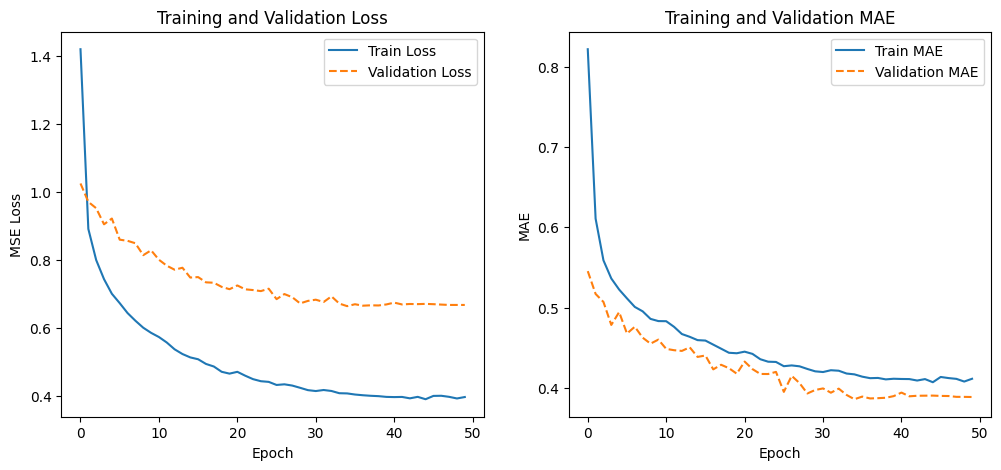

In [ ]:
# === Plot Training and Validation Loss and MAE ===
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE', linestyle='--')
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

In [ ]:
# Debug: Verify prediction lengths
print(f"Prediction lengths: y_val_true={len(y_val_true)}, y_val_pred={len(y_val_pred)}, y_test_true={len(y_test_true)}, y_test_pred={len(y_test_pred)}")


Prediction lengths: y_val_true=2861, y_val_pred=2861, y_test_true=3648, y_test_pred=3648


In [ ]:
# Define the results directory (same as in your code)
results_dir = '/content/drive/MyDrive/MINI01/pp2_models/'
os.makedirs(results_dir, exist_ok=True)

# Save the model
model_save_path = os.path.join(results_dir, 'lstm_gru_model_0.7.h5')
model.save(model_save_path, save_format='h5')
print(f"Model saved to: {model_save_path}")

Model saved to: /content/drive/MyDrive/MINI01/pp2_models/lstm_gru_model_0.7.h5
